# Data Science Research Methods Report-2

## **Introduction**<br>
The PAMAP2 Physical Activity Monitoring dataset (available here) contains data from 9 participants who participated in 18 various physical activities (such as walking, cycling, and soccer) while wearing three inertial measurement units (IMUs) and a heart rate monitor. This information is saved in separate text files for each subject. The goal is to build hardware and/or software that can determine the amount and type of physical activity performed by an individual by using insights derived from analysing the given dataset.

In [2]:
import os
import random
from collections import defaultdict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabula
from IPython.display import display
from matplotlib import rcParams
from numpy.fft import rfft
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import ranksums, ttest_ind
from sklearn import cluster, preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             homogeneity_score, log_loss, silhouette_score,
                             v_measure_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler

In [3]:
os.chdir("/home/sahil/Downloads/PAMAP2_Dataset/")  # Setting up working directory
import warnings

In [4]:
warnings.filterwarnings("ignore")

## Data Cleaning<br>
For tidying up the data :<br>
- We load the data of various subjects and give relevant column names<br>
  for various features.<br>
- The data for all subjects are then stacked together to form one table.<br>
- We remove the 'Orientation' columns because it was mentioned<br>
  in the data report that it is invalid in this data collection.<br>
- Similarly, the rows with Activity ID "0" are also removed as<br>
  it does not relate to any specific activity.<br>
- The missing values are filled up using the linear interpolation method.<br>
- Added a new feature, 'BMI' or Body Mass Index for the 'subject_detail' table<br>
- Additional feature, 'Activity Type' is added to the data which classifies activities<br>
  into 3 classes, 'Light' activity,'Moderate' activity and 'Intense' activity.<br>
  1. Lying,sitting,ironing and standing are labelled as 'light' activities.<br>
  2. Vacuum cleaning,descending stairs,normal walking,Nordic walking and cycling are<br>
     considered as 'Moderate' activities<br>
  3. Ascending stairs,running and rope jumping are labelled as 'Intense' activities.<br>
  This classification makes it easier to perform hypothesis testing between pair of attributes.


<br>
Given below are functions to give relevant names to the columns and create a<br>
single table containing data for all subjects<br>


In [ ]:
def gen_activity_names():
    # Using this function all the activity names are mapped to their ids
    act_name = {}
    act_name[0] = "transient"
    act_name[1] = "lying"
    act_name[2] = "sitting"
    act_name[3] = "standing"
    act_name[4] = "walking"
    act_name[5] = "running"
    act_name[6] = "cycling"
    act_name[7] = "Nordic_walking"
    act_name[9] = "watching_TV"
    act_name[10] = "computer_work"
    act_name[11] = "car driving"
    act_name[12] = "ascending_stairs"
    act_name[13] = "descending_stairs"
    act_name[16] = "vacuum_cleaning"
    act_name[17] = "ironing"
    act_name[18] = "folding_laundry"
    act_name[19] = "house_cleaning"
    act_name[20] = "playing_soccer"
    act_name[24] = "rope_jumping"
    return act_name

In [ ]:
def generate_three_IMU(name):
    x = name + "_x"
    y = name + "_y"
    z = name + "_z"
    return [x, y, z]

In [ ]:
def generate_four_IMU(name):
    x = name + "_x"
    y = name + "_y"
    z = name + "_z"
    w = name + "_w"
    return [x, y, z, w]

In [ ]:
def generate_cols_IMU(name):
    # temp
    temp = name + "_temperature"
    output = [temp]
    # acceleration 16
    acceleration16 = name + "_3D_acceleration_16"
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name + "_3D_acceleration_6"
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name + "_3D_gyroscope"
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name + "_3D_magnetometer"
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name + "_4D_orientation"
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

In [ ]:
def load_IMU():
    output = ["time_stamp", "activity_id", "heart_rate"]
    hand = "hand"
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = "chest"
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = "ankle"
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

In [ ]:
def load_subjects(
    root1="/home/sahil/Downloads/PAMAP2_Dataset/Protocol/subject",
    root2="/home/sahil/Downloads/PAMAP2_Dataset/Optional/subject",
):
    cols = load_IMU()
    output = pd.DataFrame()
    for i in range(101, 110):
        path1 = root1 + str(i) + ".dat"
        subject = pd.DataFrame()
        subject_prot = pd.read_table(path1, header=None, sep="\s+")  # subject data from
        # protocol activities
        subject = subject.append(subject_prot)
        subject.columns = cols
        subject = subject.sort_values(
            by="time_stamp"
        )  # Arranging all measurements according to
        # time
        subject["id"] = i
        output = output.append(subject, ignore_index=True)
    return output

In [ ]:
data = load_subjects()  # Add your own location for the data here to replicate the code
# for eg data = load_subjects('filepath')
data = data.drop(
    data[data["activity_id"] == 0].index
)  # Removing rows with activity id of 0
act = gen_activity_names()
data["activity_name"] = data.activity_id.apply(lambda x: act[x])
data = data.drop(
    [i for i in data.columns if "orientation" in i], axis=1
)  # Dropping Orientation  columns
cols_6g = [i for i in data.columns if "_6_" in i]  # 6g acceleration data columns
data = data.drop(cols_6g, axis=1)  # dropping 6g acceleration columns
display(data.head())
# Saving transformed data in pickle format becuse it has the fastest read time compared
# to all other formats
data.to_pickle("activity_data.pkl")  # Saving transformed data for future use

In [5]:
def train_test_split_by_subjects(data):  # splitting by subjects
    subjects = [
        i for i in range(101, 109)
    ]  # Eliminate subject 109  due to less activities
    train_subjects = [101, 103, 104, 105]
    test_subjects = [i for i in subjects if i not in train_subjects]
    train = data[data.id.isin(train_subjects)]  # Generating training data
    test = data[data.id.isin(test_subjects)]  # generating testing data
    return train, test

In [6]:
def split_by_activities(data):
    light = ["lying", "sitting", "standing", "ironing"]
    moderate = [
        "vacuum_cleaning",
        "descending_stairs",
        "normal_walking",
        "nordic_walking",
        "cycling",
    ]
    intense = ["ascending_stairs", "running", "rope_jumping"]
    def split(activity):  #  method for returning activity labels for activities
        if activity in light:
            return "light"
        elif activity in moderate:
            return "moderate"
        else:
            return "intense"
    data["activity_type"] = data.activity_name.apply(lambda x: split(x))
    return data

Loading data and doing the train-test split for EDA and Hypothesis testing.

In [7]:
data = pd.read_pickle("activity_data.pkl")
data = split_by_activities(data)
train, test = train_test_split_by_subjects(
    data
)  # train and test data for EDA and hypothesis testing respectively.
subj_det = tabula.read_pdf(
    "subjectInformation.pdf", pages=1
)  # loading subject detail table from pdf file.
# Eliminating unnecessary columns and fixing the column alignment of the table.
sd = subj_det[0]
new_cols = list(sd.columns)[1:9]
sd = sd[sd.columns[0:8]]
sd.columns = new_cols
subj_det = sd

Create clean data for use in modelling

In [8]:
eliminate = [
    "activity_id",
    "activity_name",
    "time_stamp",
    "id",
]  # Columns not meant to be cleaned
features = [i for i in data.columns if i not in eliminate]
clean_data = data
clean_data[features] = clean_data[features].ffill()
display(clean_data.head())

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,...,ankle_3D_acceleration_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,id,activity_name,activity_type
2928,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101,lying,light
2929,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101,lying,light
2930,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101,lying,light
2931,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101,lying,light
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101,lying,light


After using the Forward Fill method, the first four values of heart rate are still missing. So the first four rows are dropped

In [9]:
clean_data = clean_data.dropna()
display(clean_data.head())

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,...,ankle_3D_acceleration_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,id,activity_name,activity_type
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101,lying,light
2933,37.71,1,100.0,30.375,2.07165,7.25965,6.01218,0.063895,0.007175,0.024701,...,-0.098161,0.003793,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,101,lying,light
2934,37.72,1,100.0,30.375,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,...,-0.098862,0.036814,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,101,lying,light
2935,37.73,1,100.0,30.375,2.32815,7.63431,5.70686,0.200328,-0.009266,0.068567,...,-0.136998,-0.010352,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,101,lying,light
2936,37.74,1,100.0,30.375,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,...,0.133911,0.039346,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,101,lying,light


Finally, save the clean data for future use in model prediction

In [ ]:
clean_data.to_pickle("clean_act_data.pkl")

## Exploratory Data Analysis<br>
After labelling the data appropriately, we have selected 4 subjects for training set and<br>
4 subjects for testing set such that the training and testing set have approximately equal size.<br>
In the training set, we perform Exploratory Data Analysis and come up with potential hypotheses.<br>
We then test those hypotheses on the testing set.<br>
50% of data is used for training in this case(Exploratory data analysis) and the rest for testing.

Calculating BMI of the subjects

In [10]:
height_in_metres = subj_det["Height (cm)"] / 100
weight_in_kg = subj_det["Weight (kg)"]
subj_det["BMI"] = weight_in_kg / (height_in_metres) ** 2

### Data Visualizations

* Bar chart for frequency of activities.

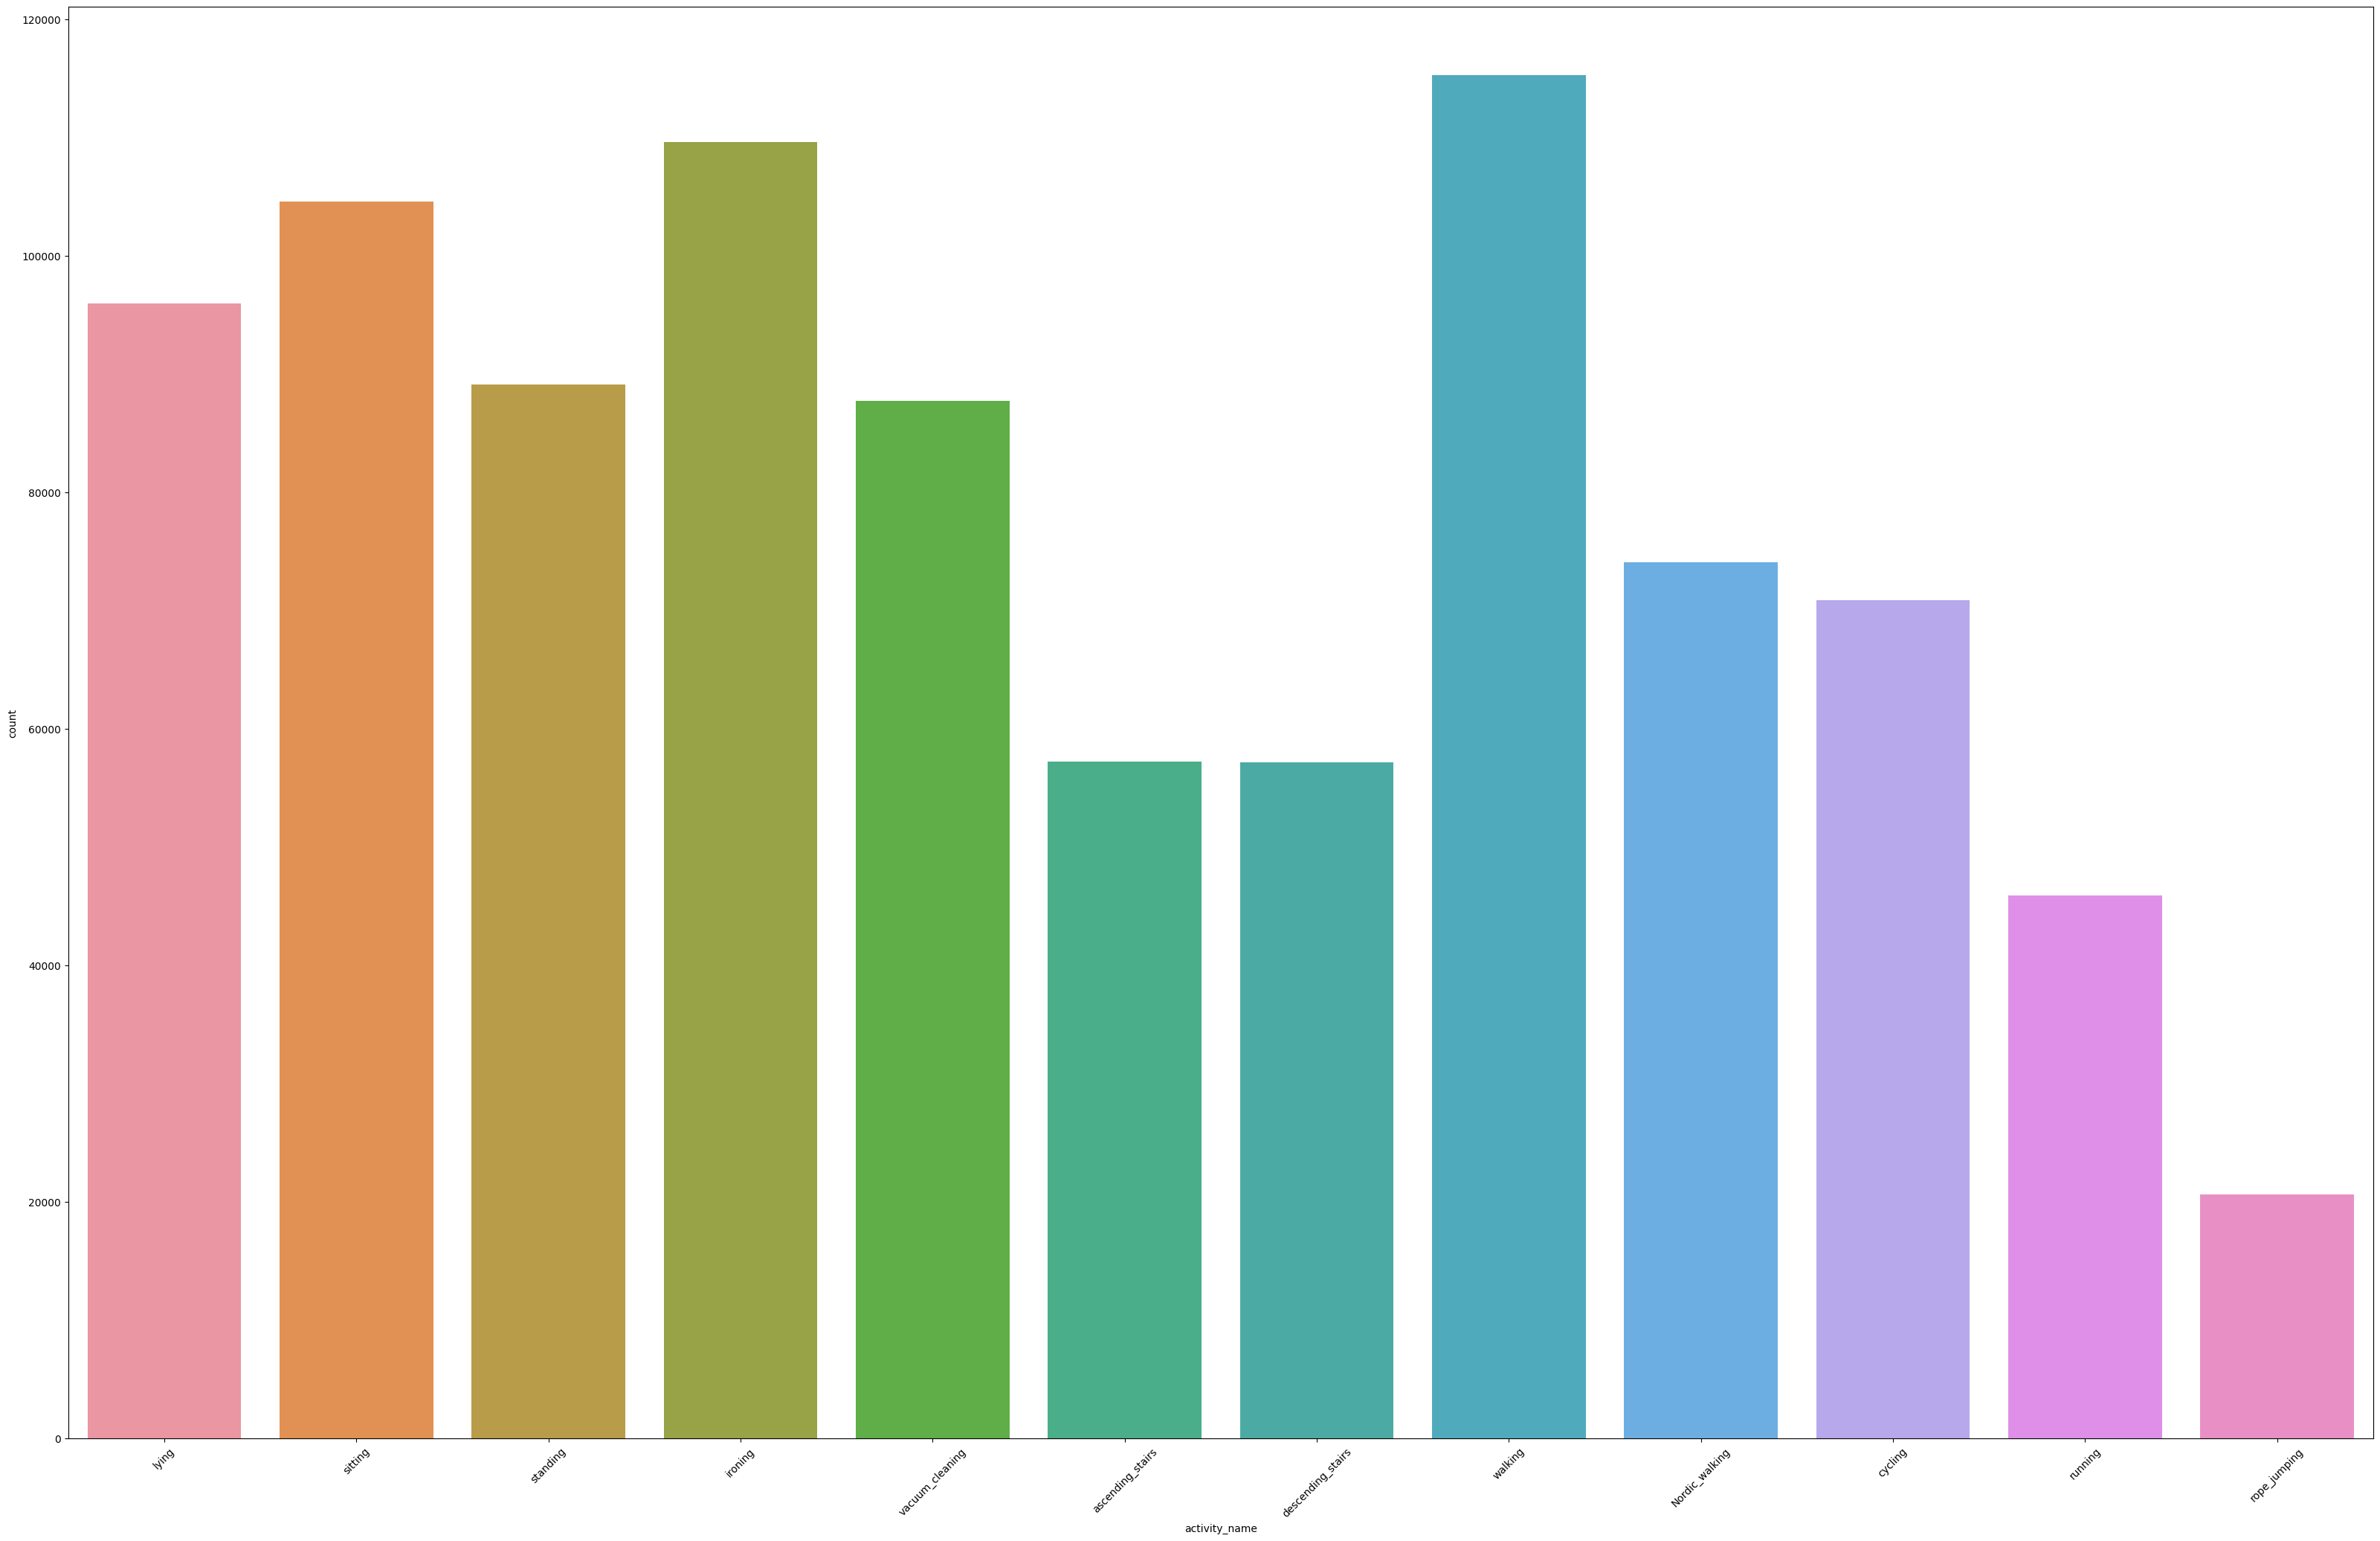

In [11]:
rcParams["figure.figsize"] = 40, 25
ax = sns.countplot(x="activity_name", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotating Text
plt.show()

* 3D scatter plot of chest acceleration coordinates for lying<br>
<br>
  It is expected that vertical chest acceleration will be more while lying due to the<br>
  movements involved and an attempt is made to check this visually over here.

<Figure size 4000x2500 with 0 Axes>

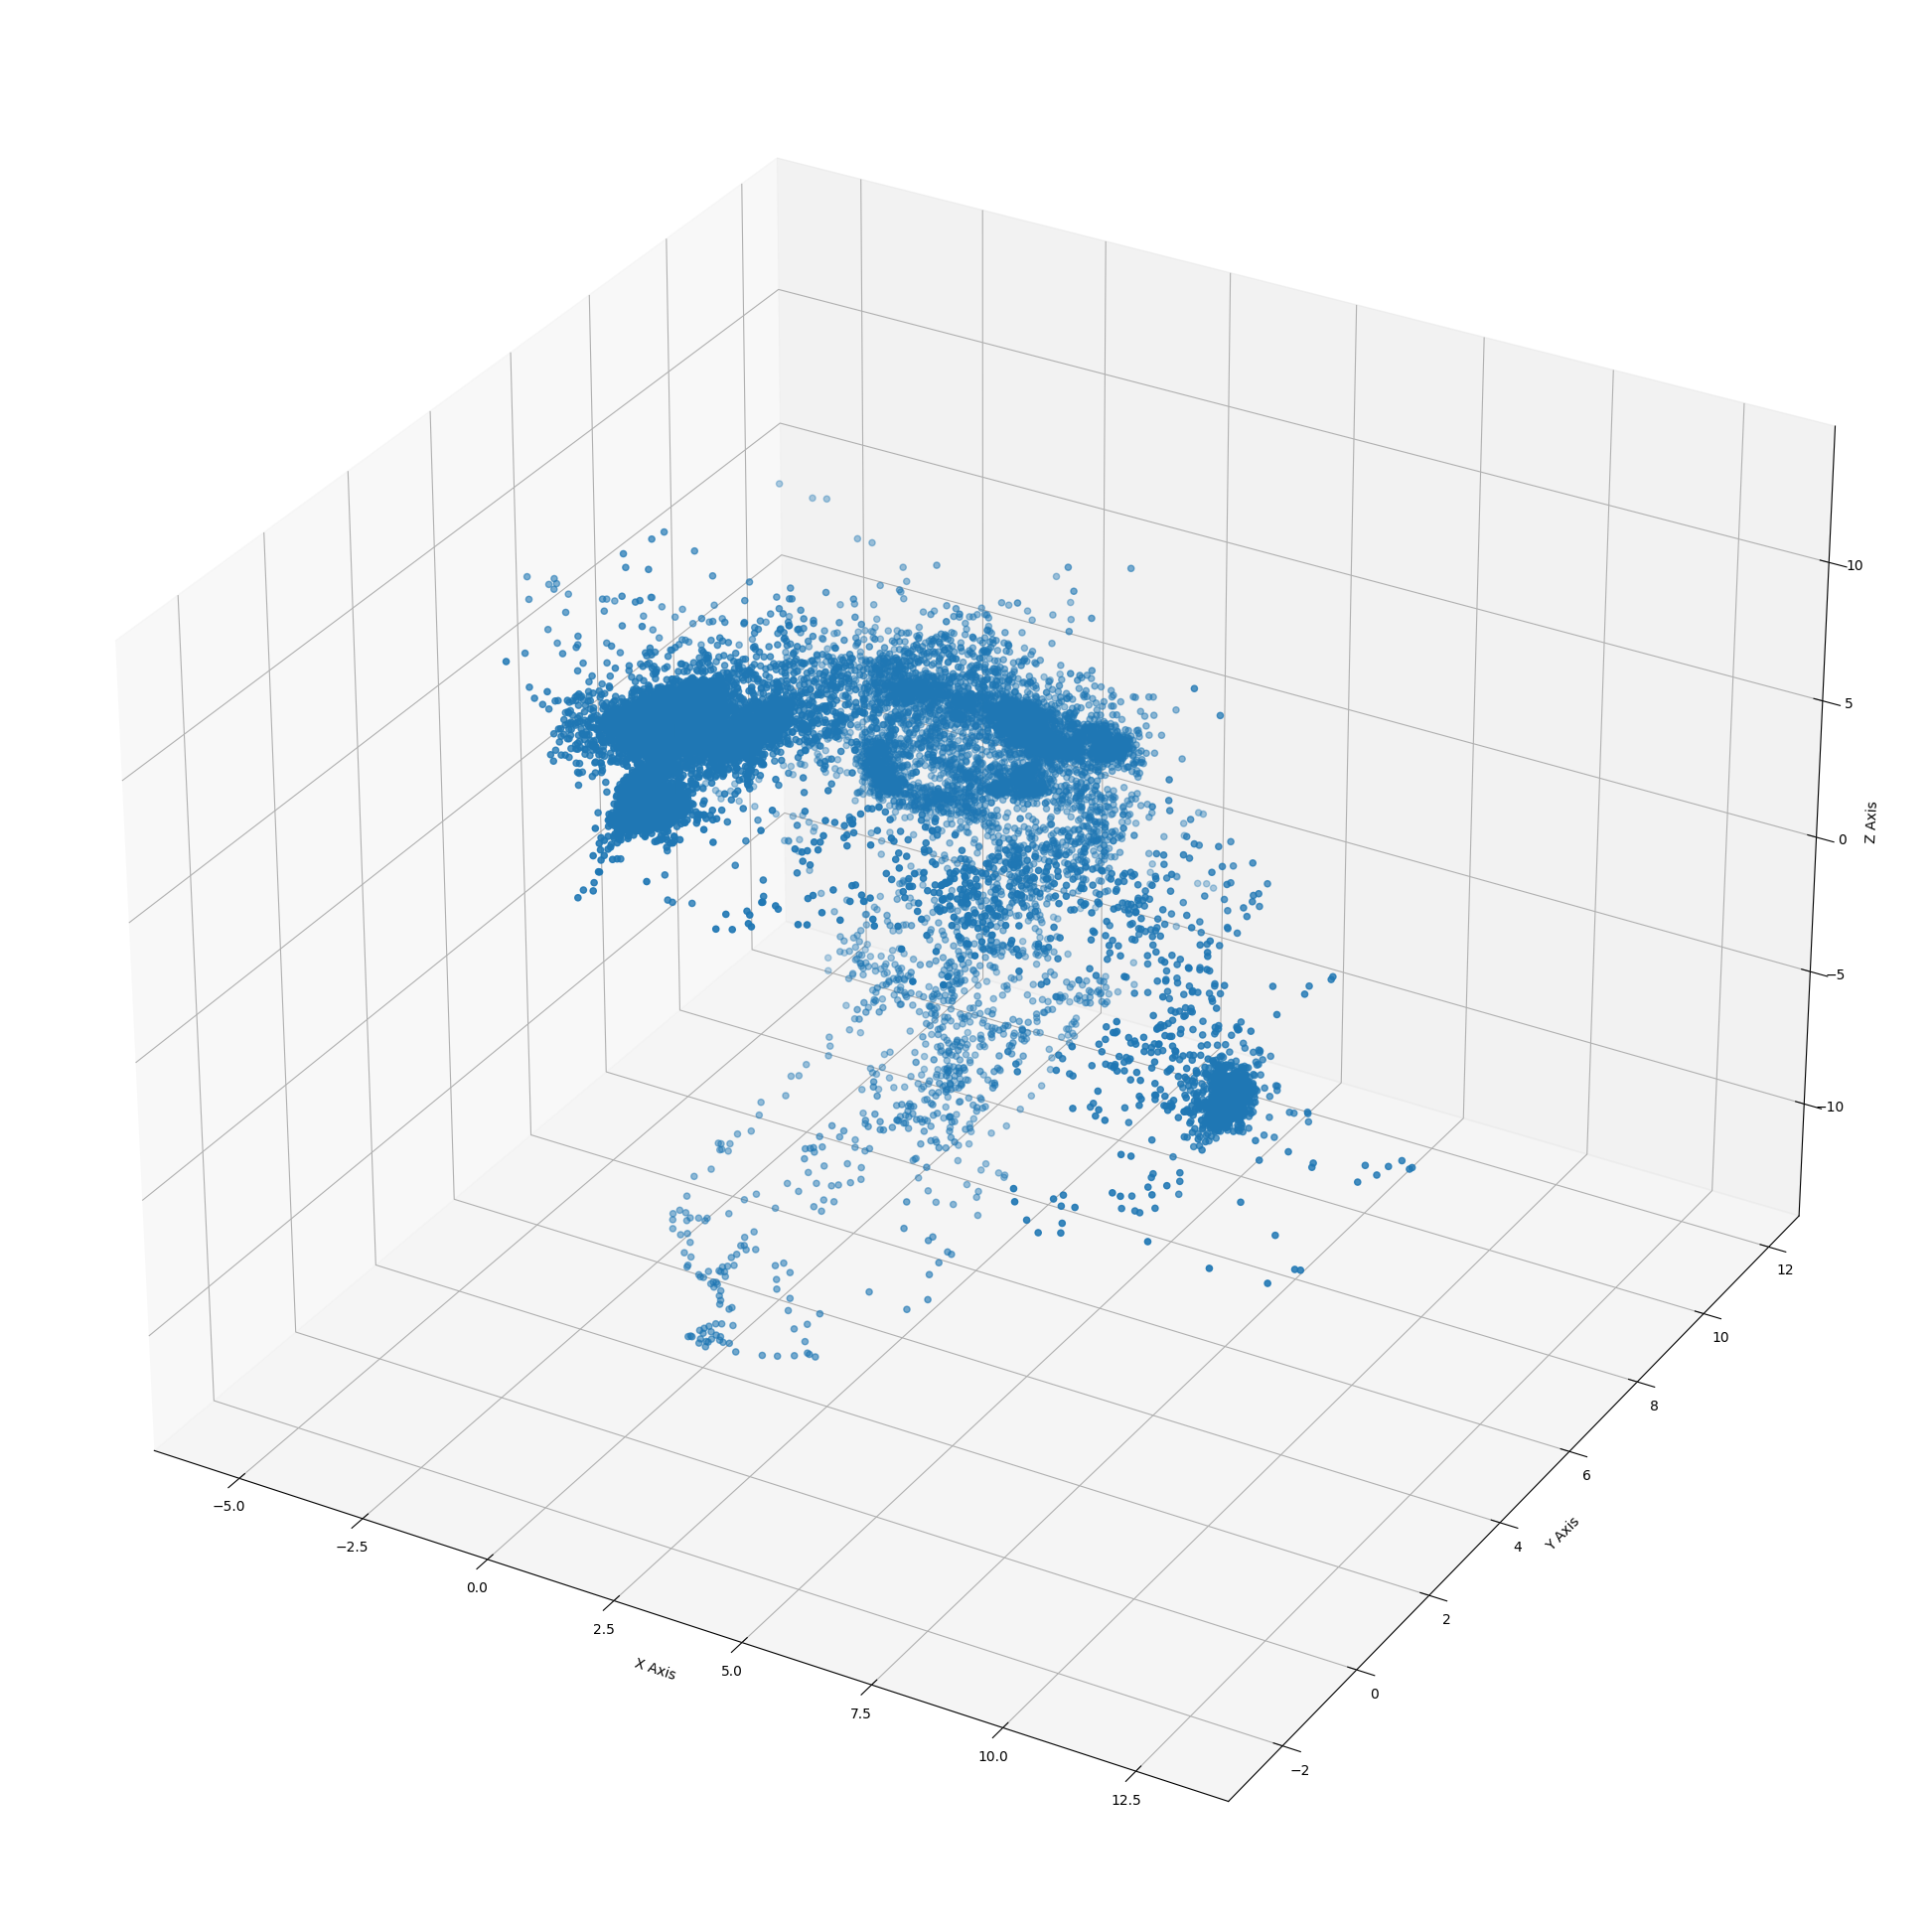

In [12]:
plt.clf()
train_running = train[train.activity_name == "lying"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
x = train_running["chest_3D_acceleration_16_x"]
y = train_running["chest_3D_acceleration_16_y"]
z = train_running["chest_3D_acceleration_16_z"]
ax.scatter(x, y, z)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.show()

   As we see, there seems to be more variance along the z axis(vertical direction) than the<br>
   x and y axis.

* 3D scatter plot of chest acceleration coordinates for running<br>
<br>
  Since running involves mostly horizontal movements for the chest, we expect<br>
  most of chest acceleration data to lie on the horizontal x amd y axis.

<Figure size 4000x2500 with 0 Axes>

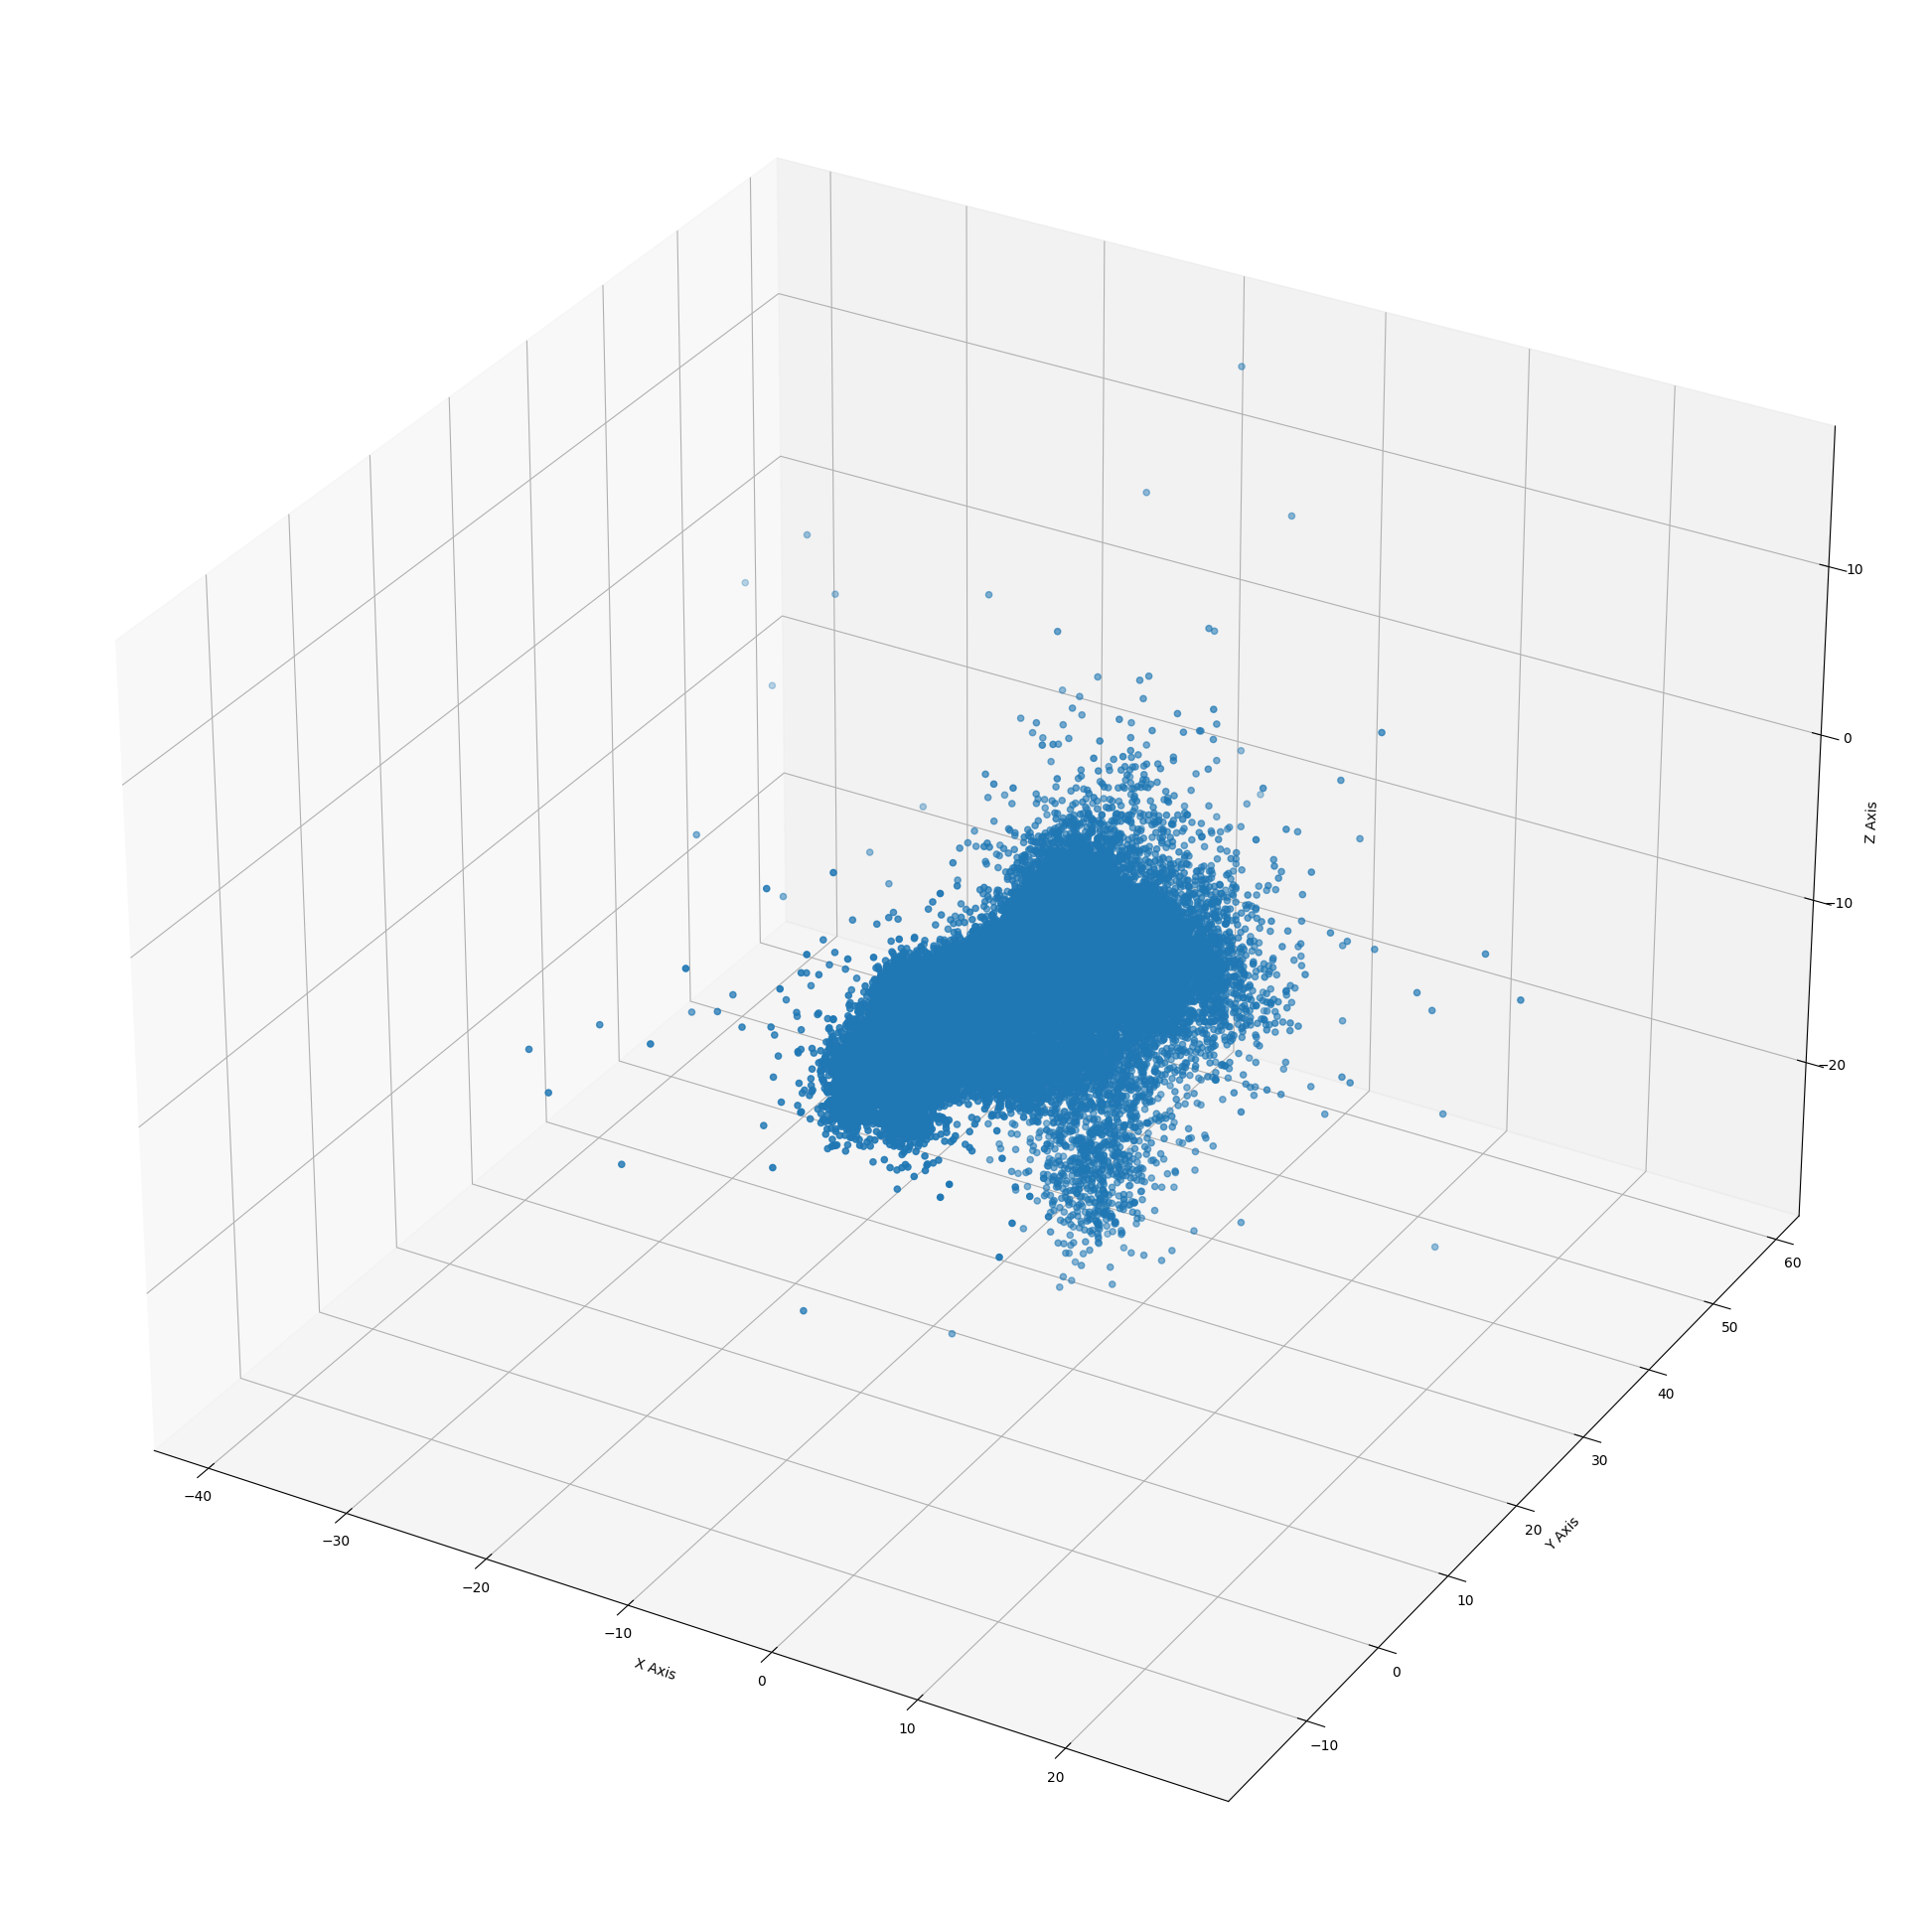

In [13]:
plt.clf()
train_running = train[train.activity_name == "running"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
x = train_running["chest_3D_acceleration_16_x"]
y = train_running["chest_3D_acceleration_16_y"]
z = train_running["chest_3D_acceleration_16_z"]
ax.scatter(x, y, z)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
plt.show()

  As we expected, for running, most of the points lie along the x and y axis.

* Time series plot of z axis chest acceleration

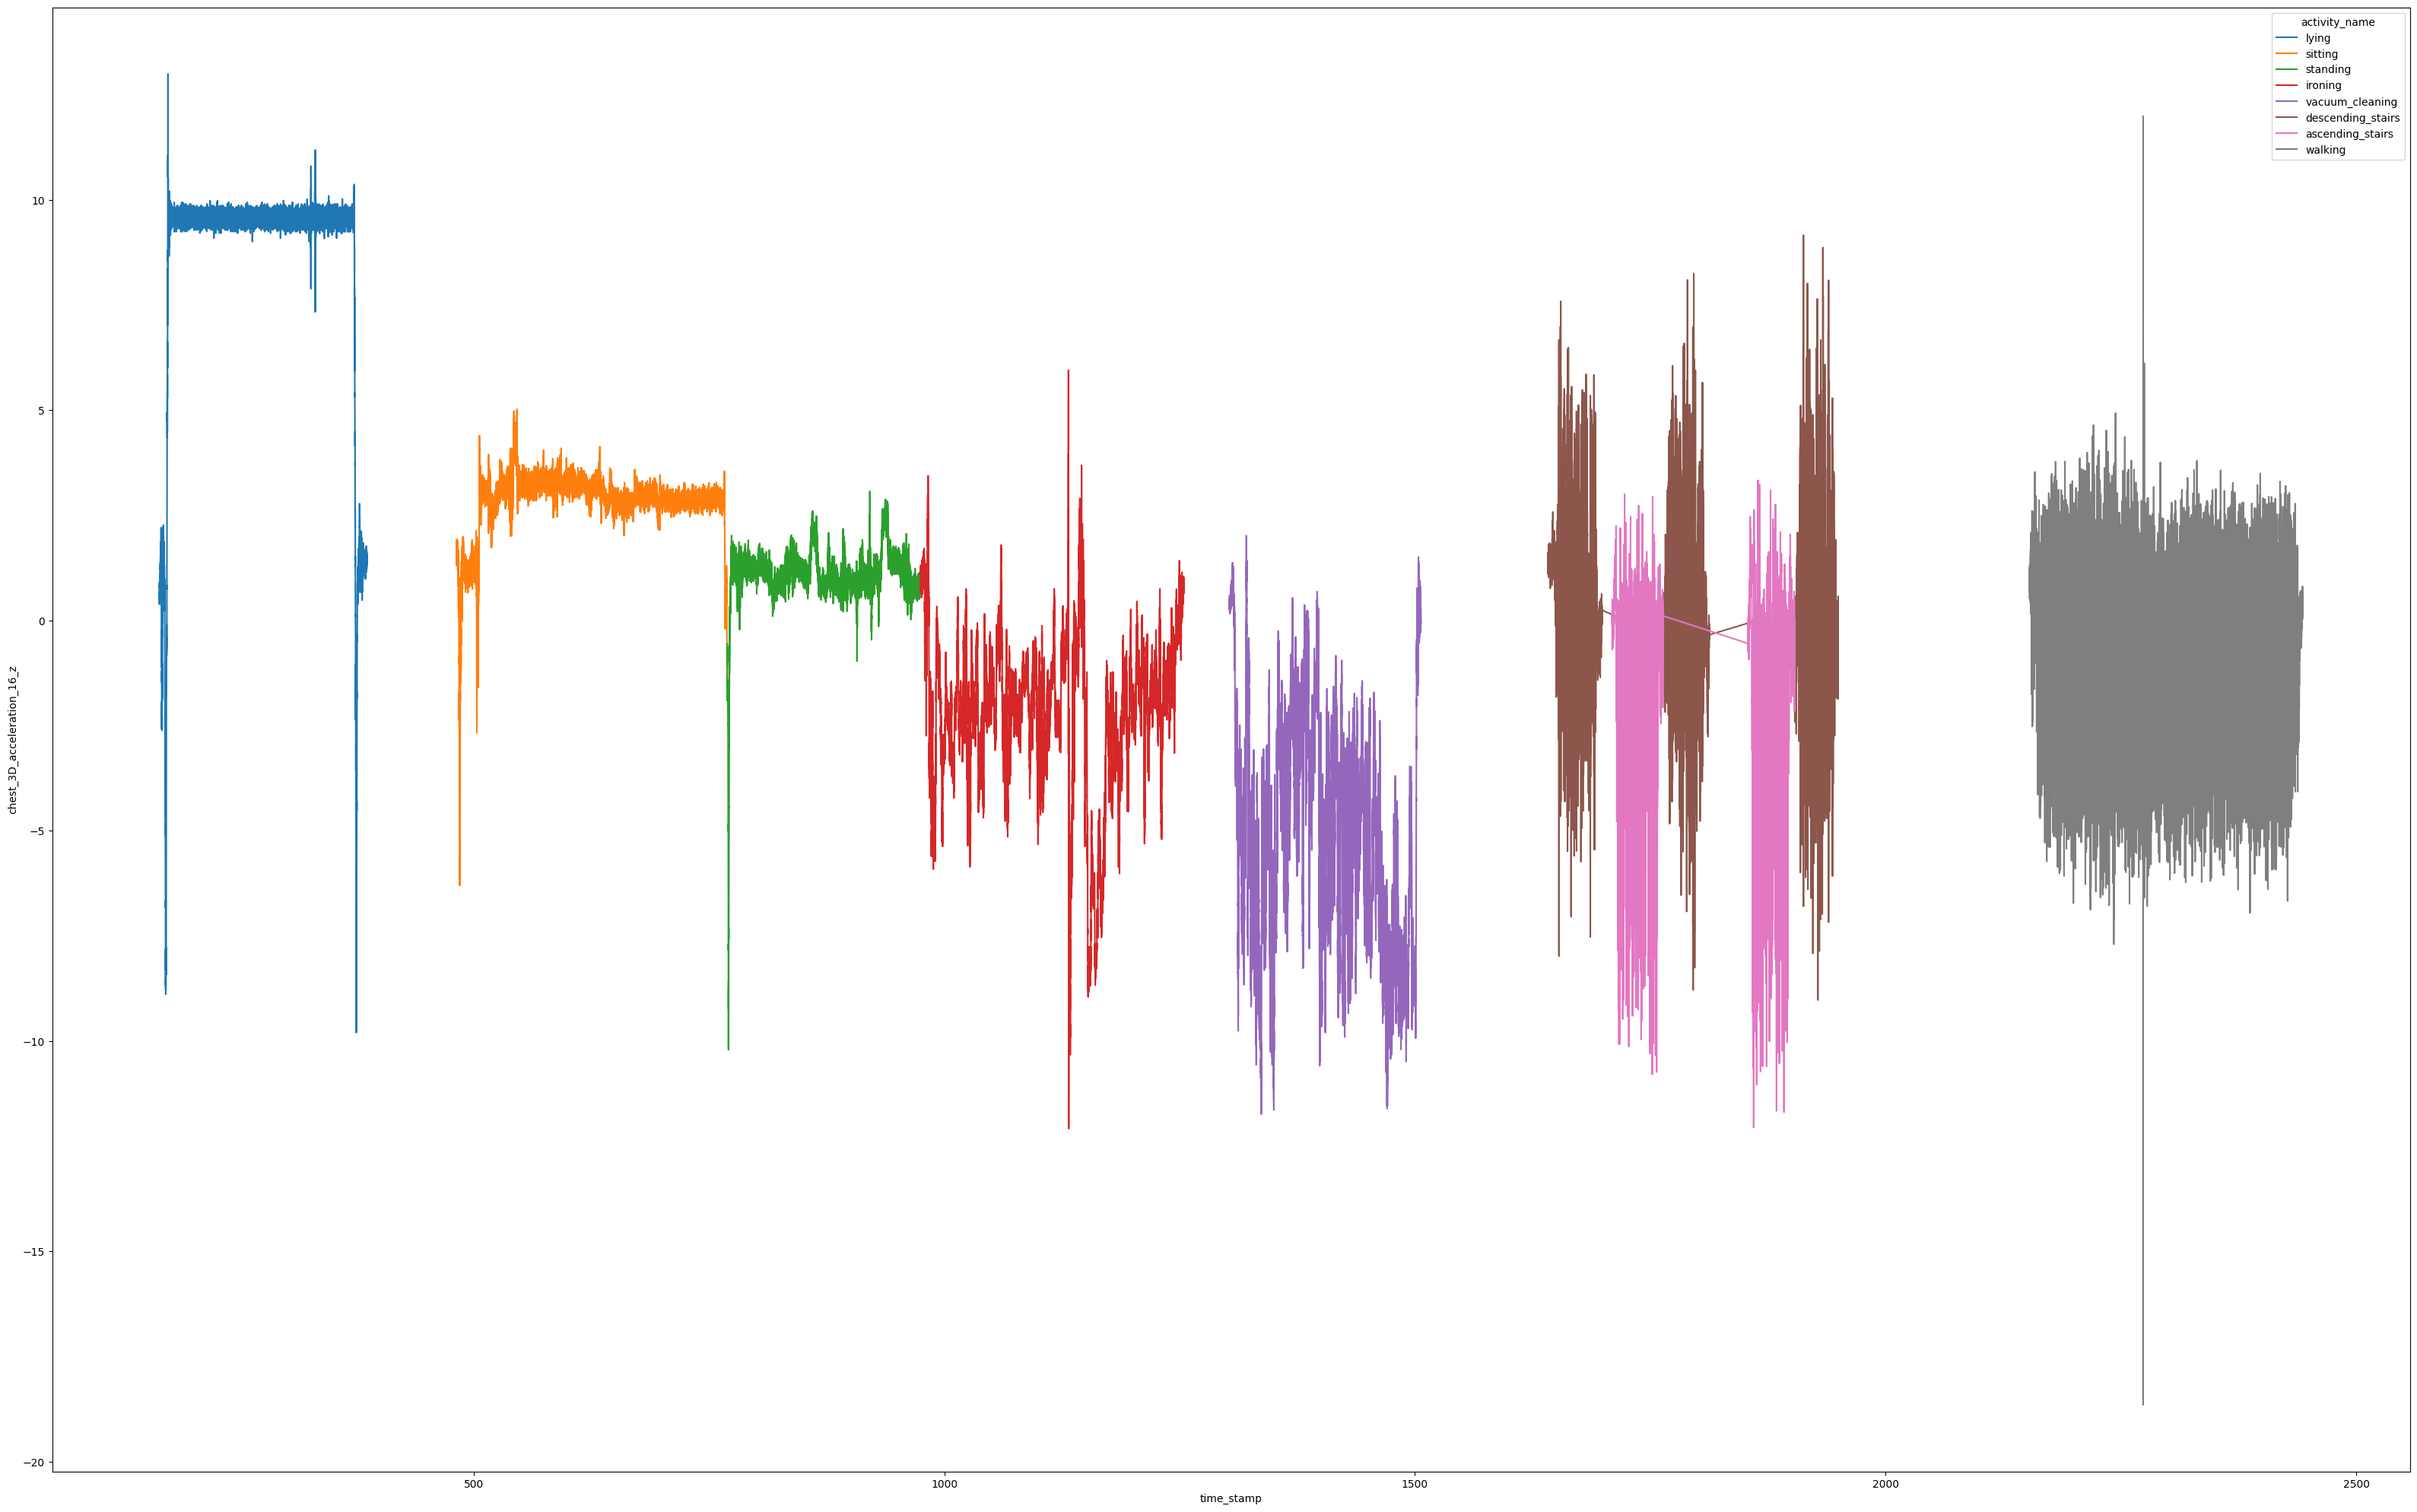

In [14]:
plt.clf()
random.seed(4)
train1 = train[train.id == random.choice(train.id.unique())]
sns.lineplot(
    x="time_stamp", y="chest_3D_acceleration_16_z", hue="activity_name", data=train1
)
plt.show()

* Boxplot of heart rate grouped by activity type.

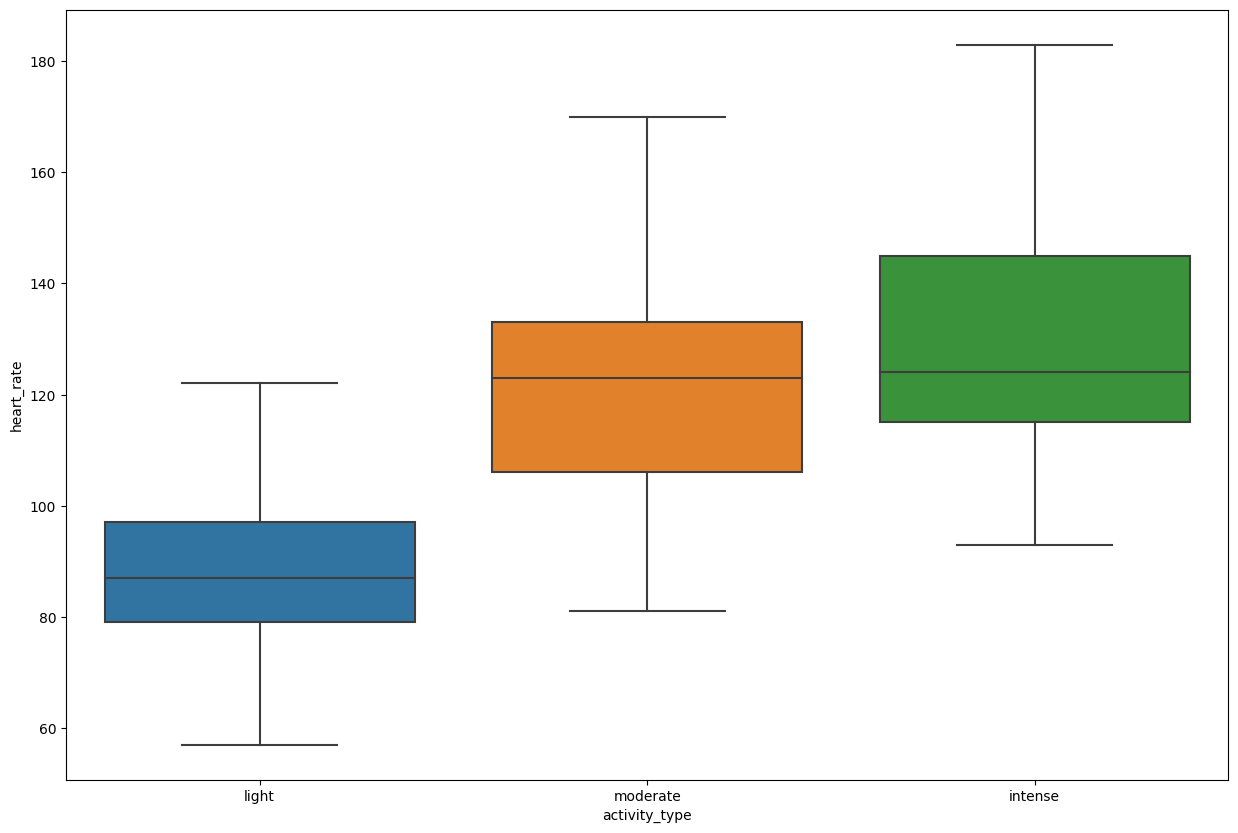

In [15]:
rcParams["figure.figsize"] = 15, 10
ax = sns.boxplot(x="activity_type", y="heart_rate", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotating Text
plt.show()

 1. It is observed that moderate and intense activities have higher heart rate than<br>
    light activities as expected.<br>
 2. There doesn't seem to be much seperation between moderate and intesne activity<br>
    heart rate.

* Boxplot of heart rate grouped by activity.

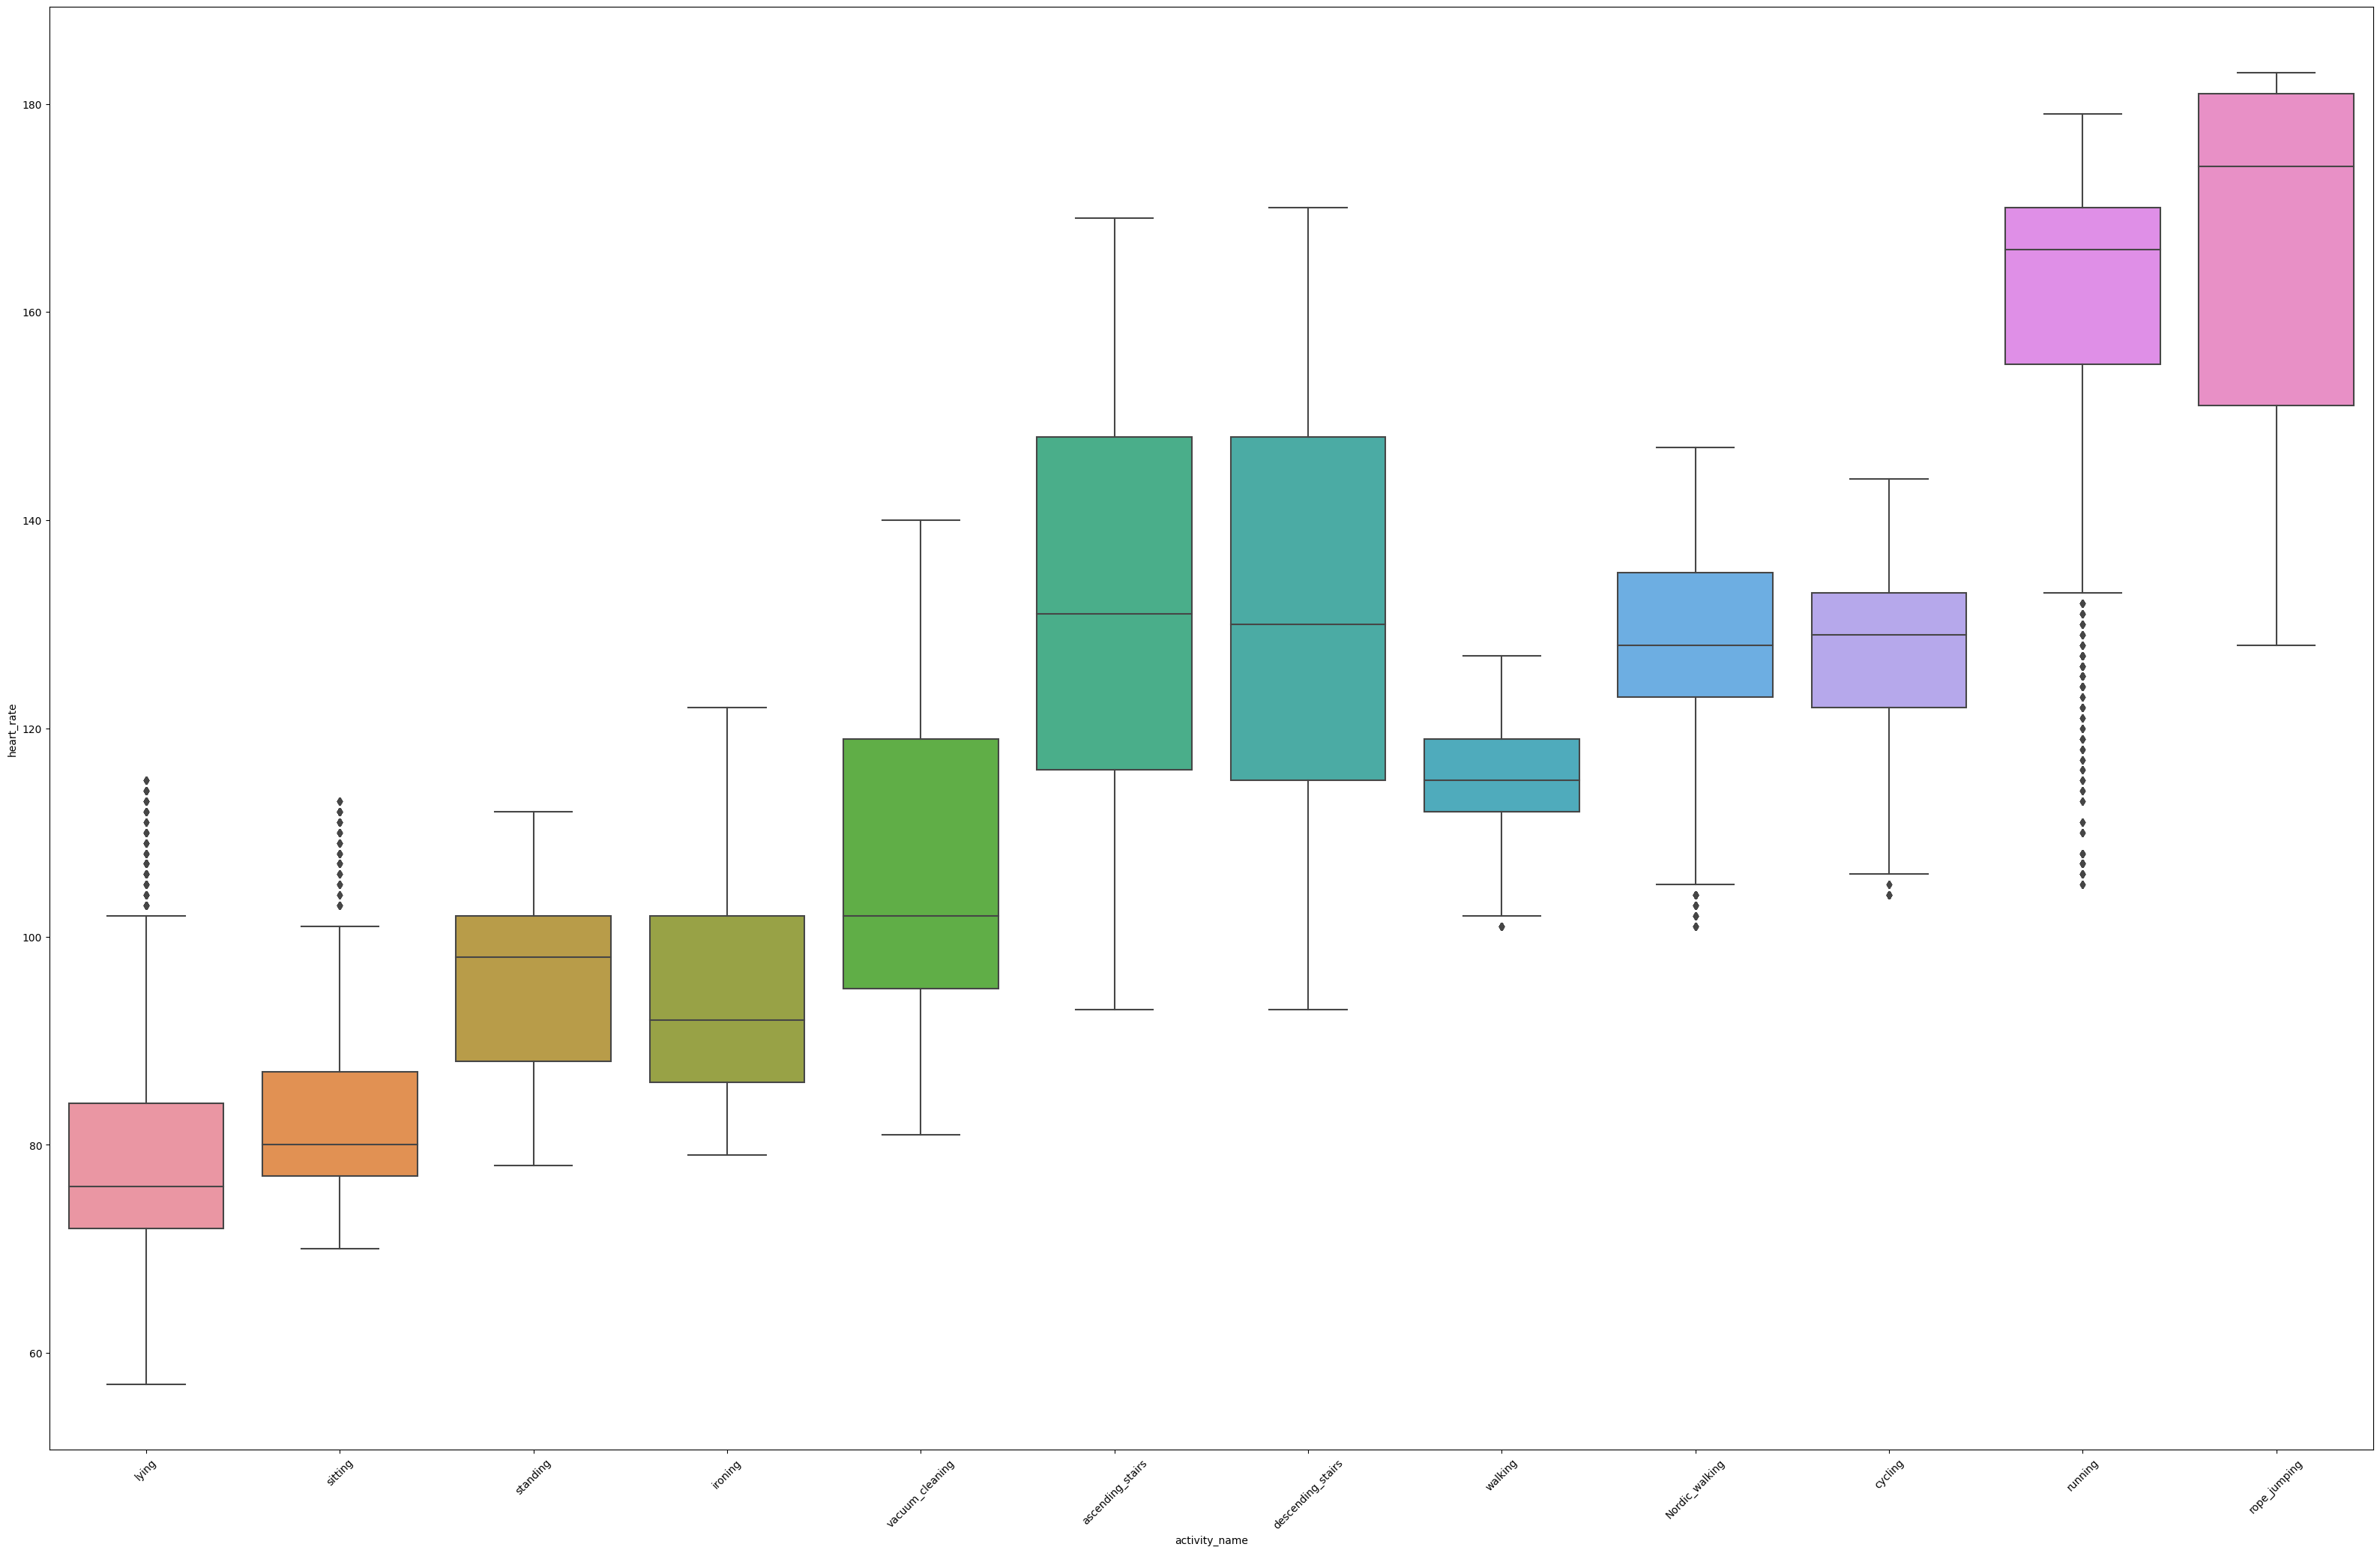

In [16]:
rcParams["figure.figsize"] = 40, 25
ax = sns.boxplot(x="activity_name", y="heart_rate", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotating Text
plt.show()

  1.  Most of the activities have a skewed distribution for heart rate.<br>
  2. 'Nordic_walking','running' and 'cycling' have a lot of outliers on the lower side.<br>
  3.  Activities like 'lying','sitting' and 'standing' have a lot of outliers on the upper side.

* Boxplot of hand temperature grouped by activity type.

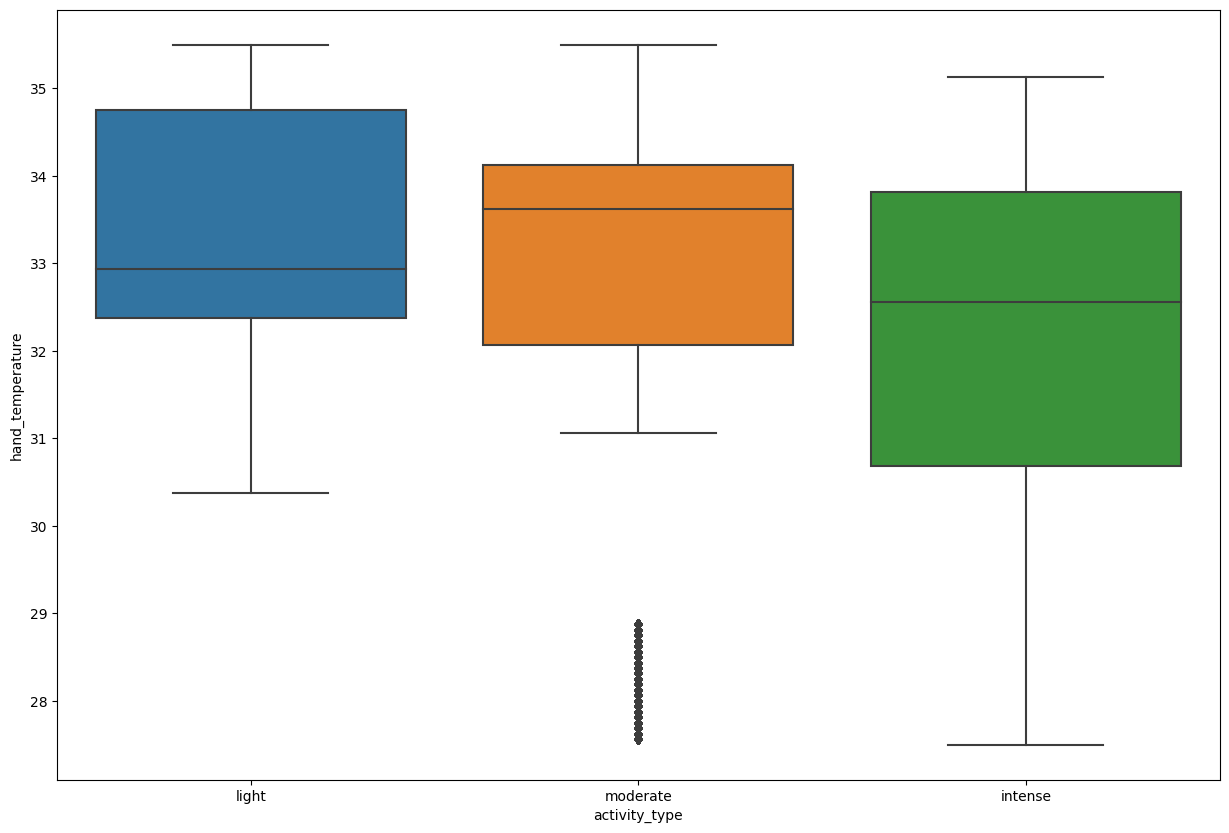

In [17]:
rcParams["figure.figsize"] = 15, 10
ax = sns.boxplot(x="activity_type", y="hand_temperature", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

1. Hand temperature of moderate activitie have a lot of outliers on the lower side.<br>
2. There doesn't seem to be much difference in temperatures between activities.

* Boxplot of hand temperature grouped by activity.

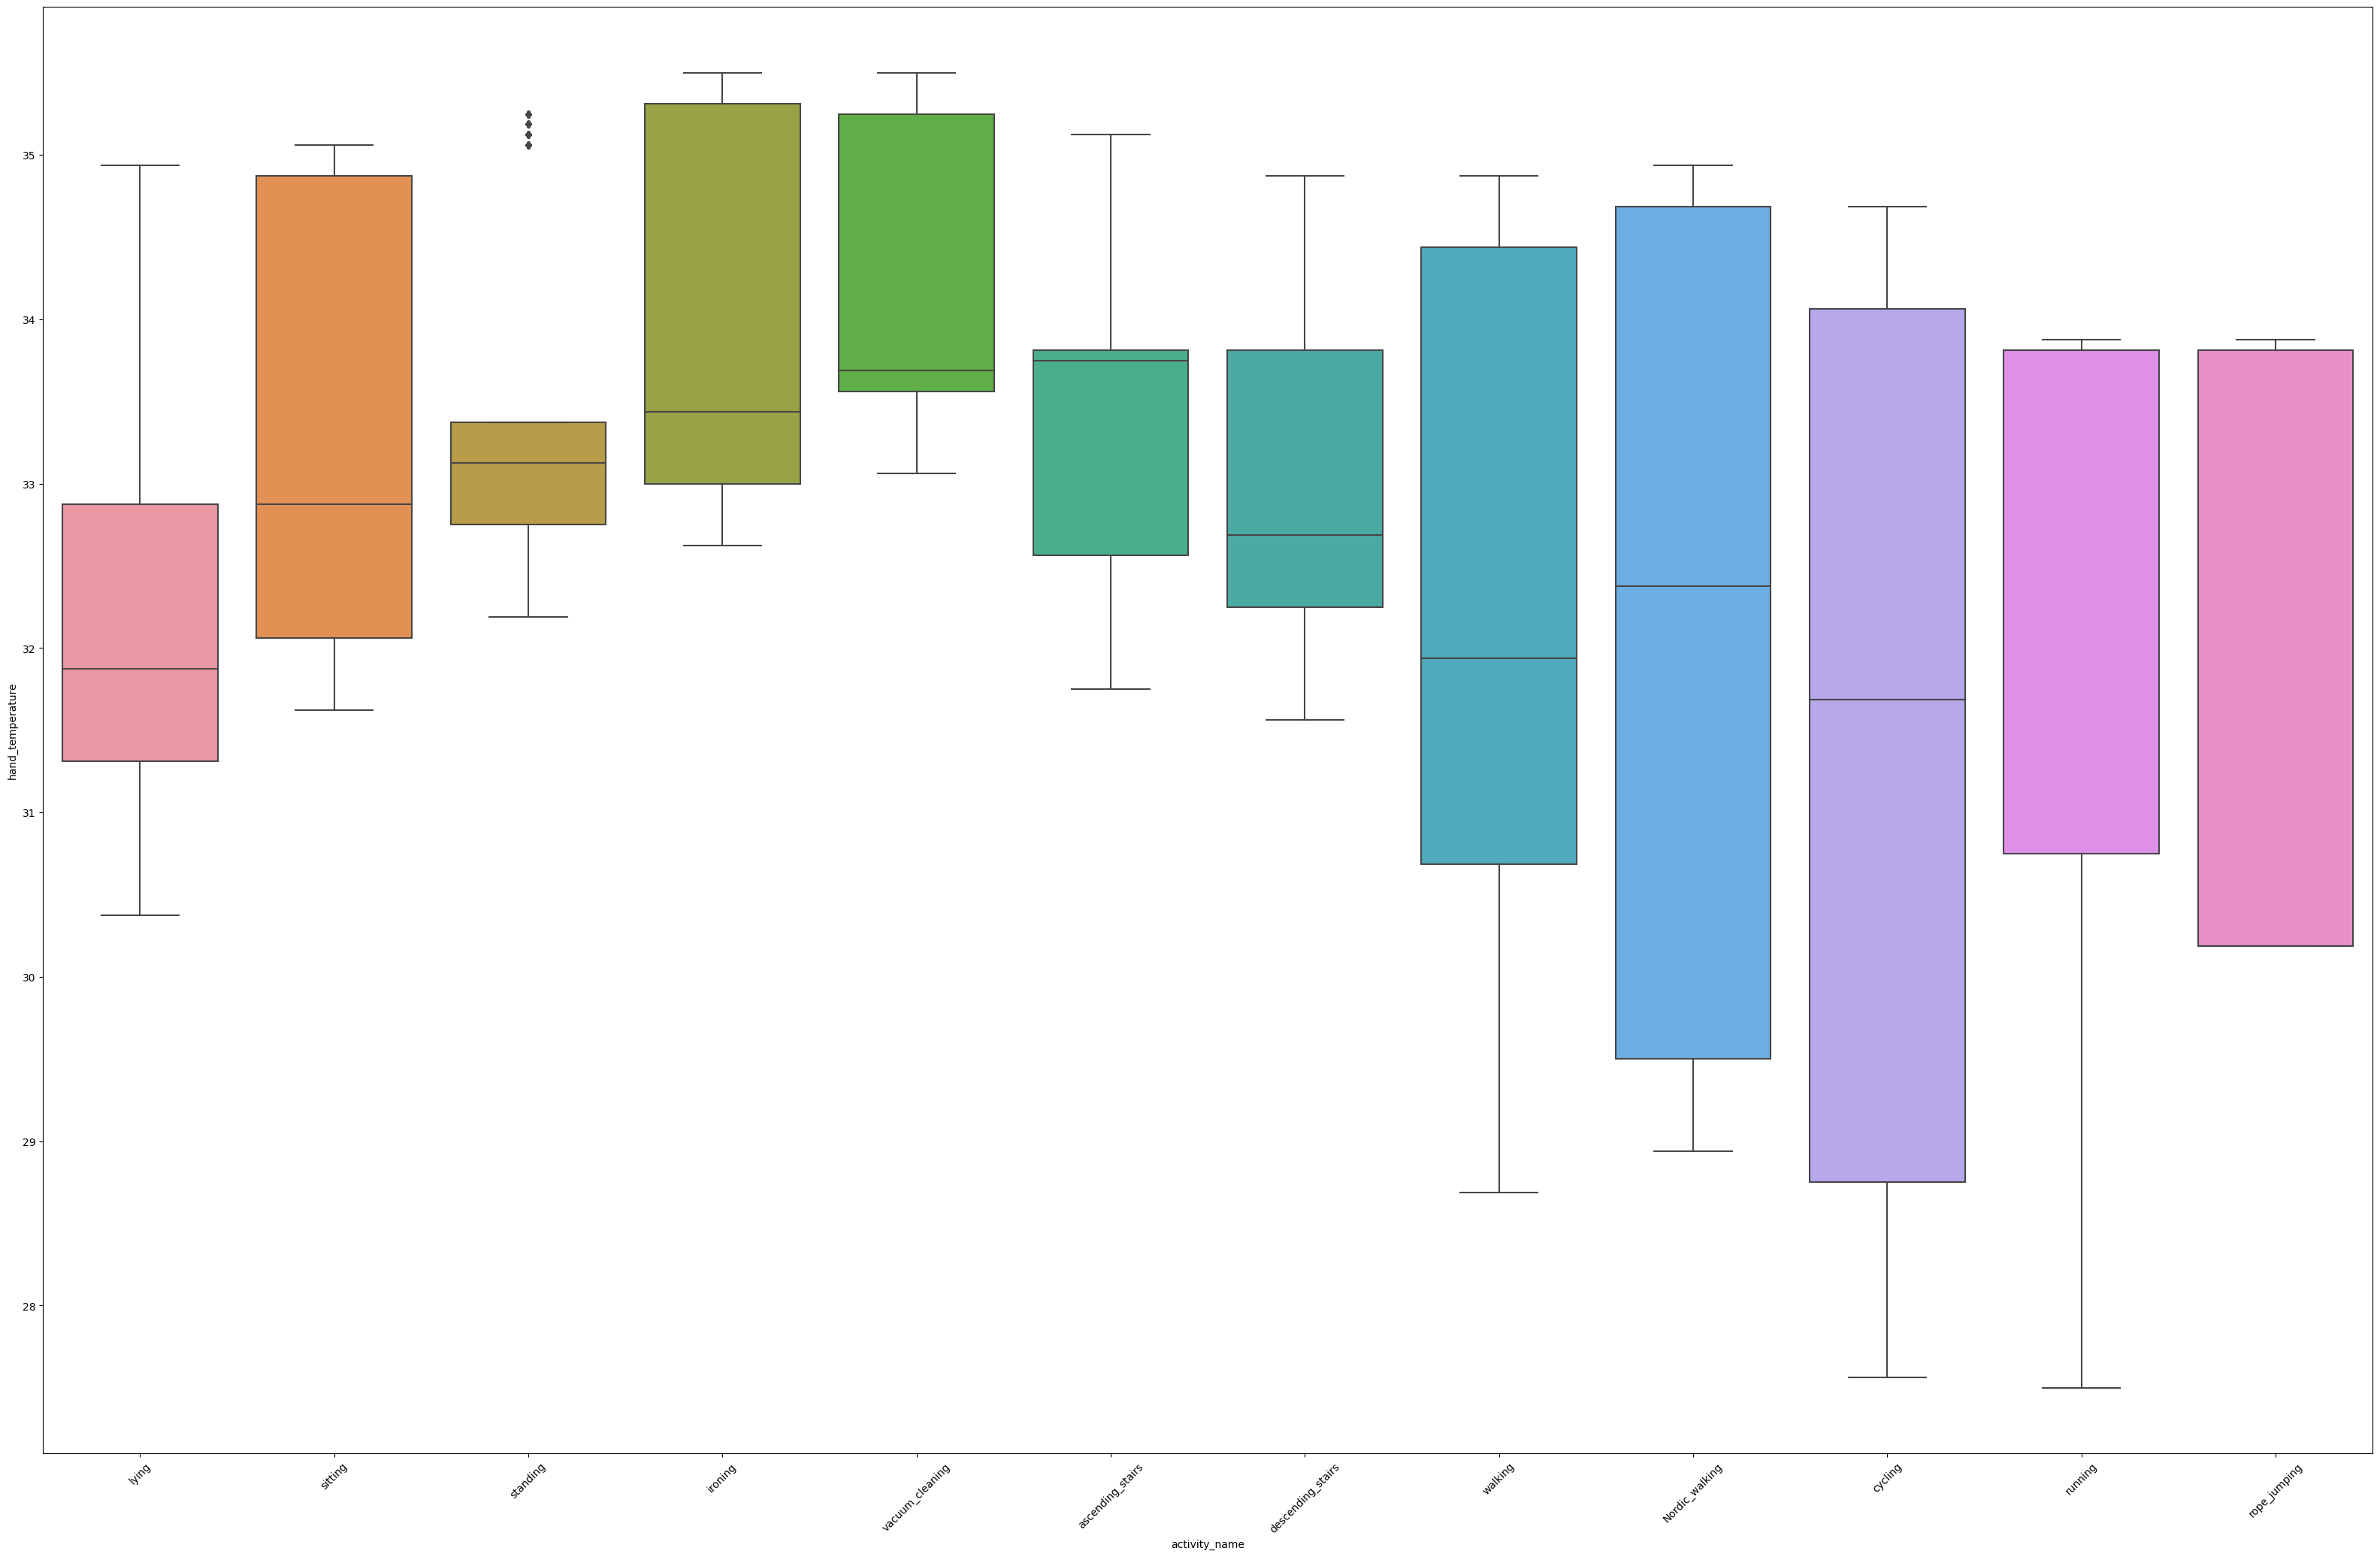

In [18]:
rcParams["figure.figsize"] = 40, 25
ax = sns.boxplot(x="activity_name", y="hand_temperature", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotating Text
plt.show()

1. Hand temperature data of 'playing_soccer' seems to have a very pronounced positive skew.<br>
2. "car_driving" and "watching_tv" have the least dispersion in hand temperature.

* Boxplot of ankle temperature grouped by activity_type

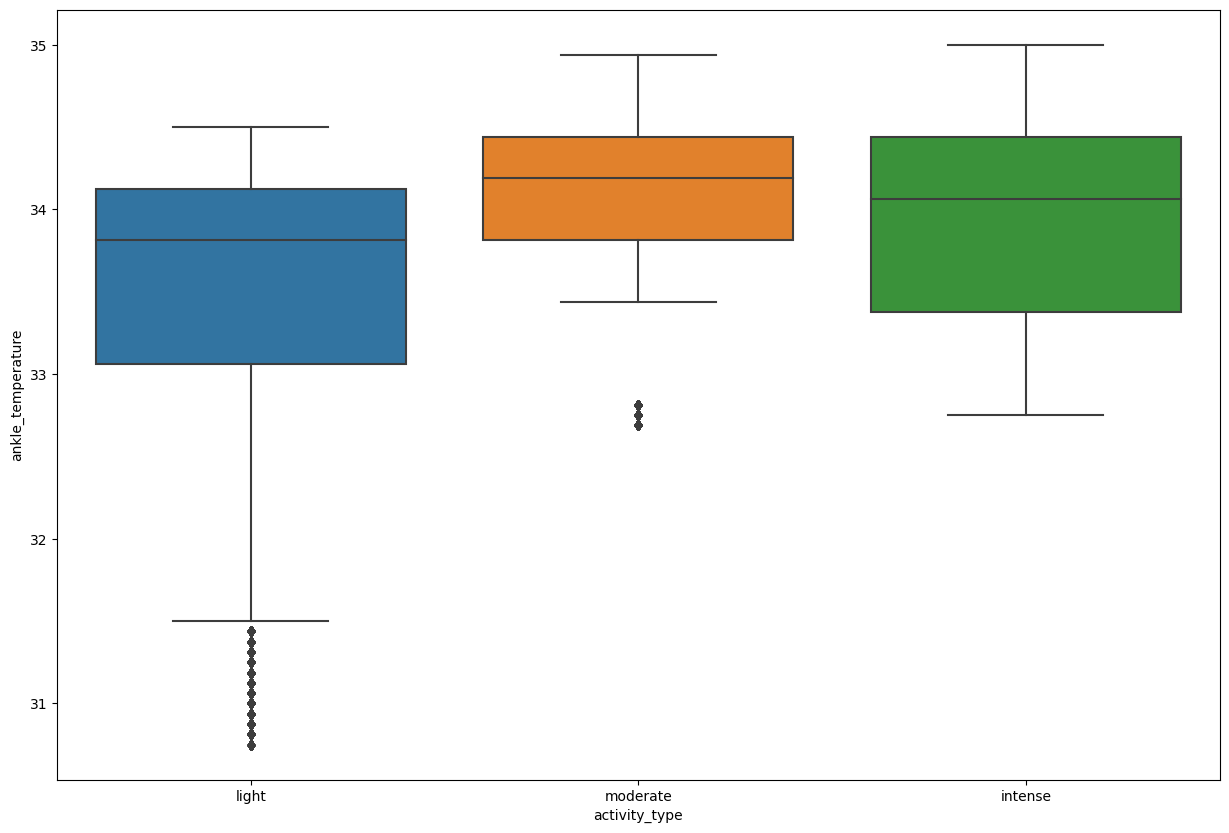

In [19]:
rcParams["figure.figsize"] = 15, 10
ax = sns.boxplot(x="activity_type", y="ankle_temperature", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

1. Ankle temperature of light and moderate activitie have  outliers on the lower side.<br>
2. There doesn't seem to be much difference in temperatures between activities.

* Boxplot of ankle temperature grouped by activity

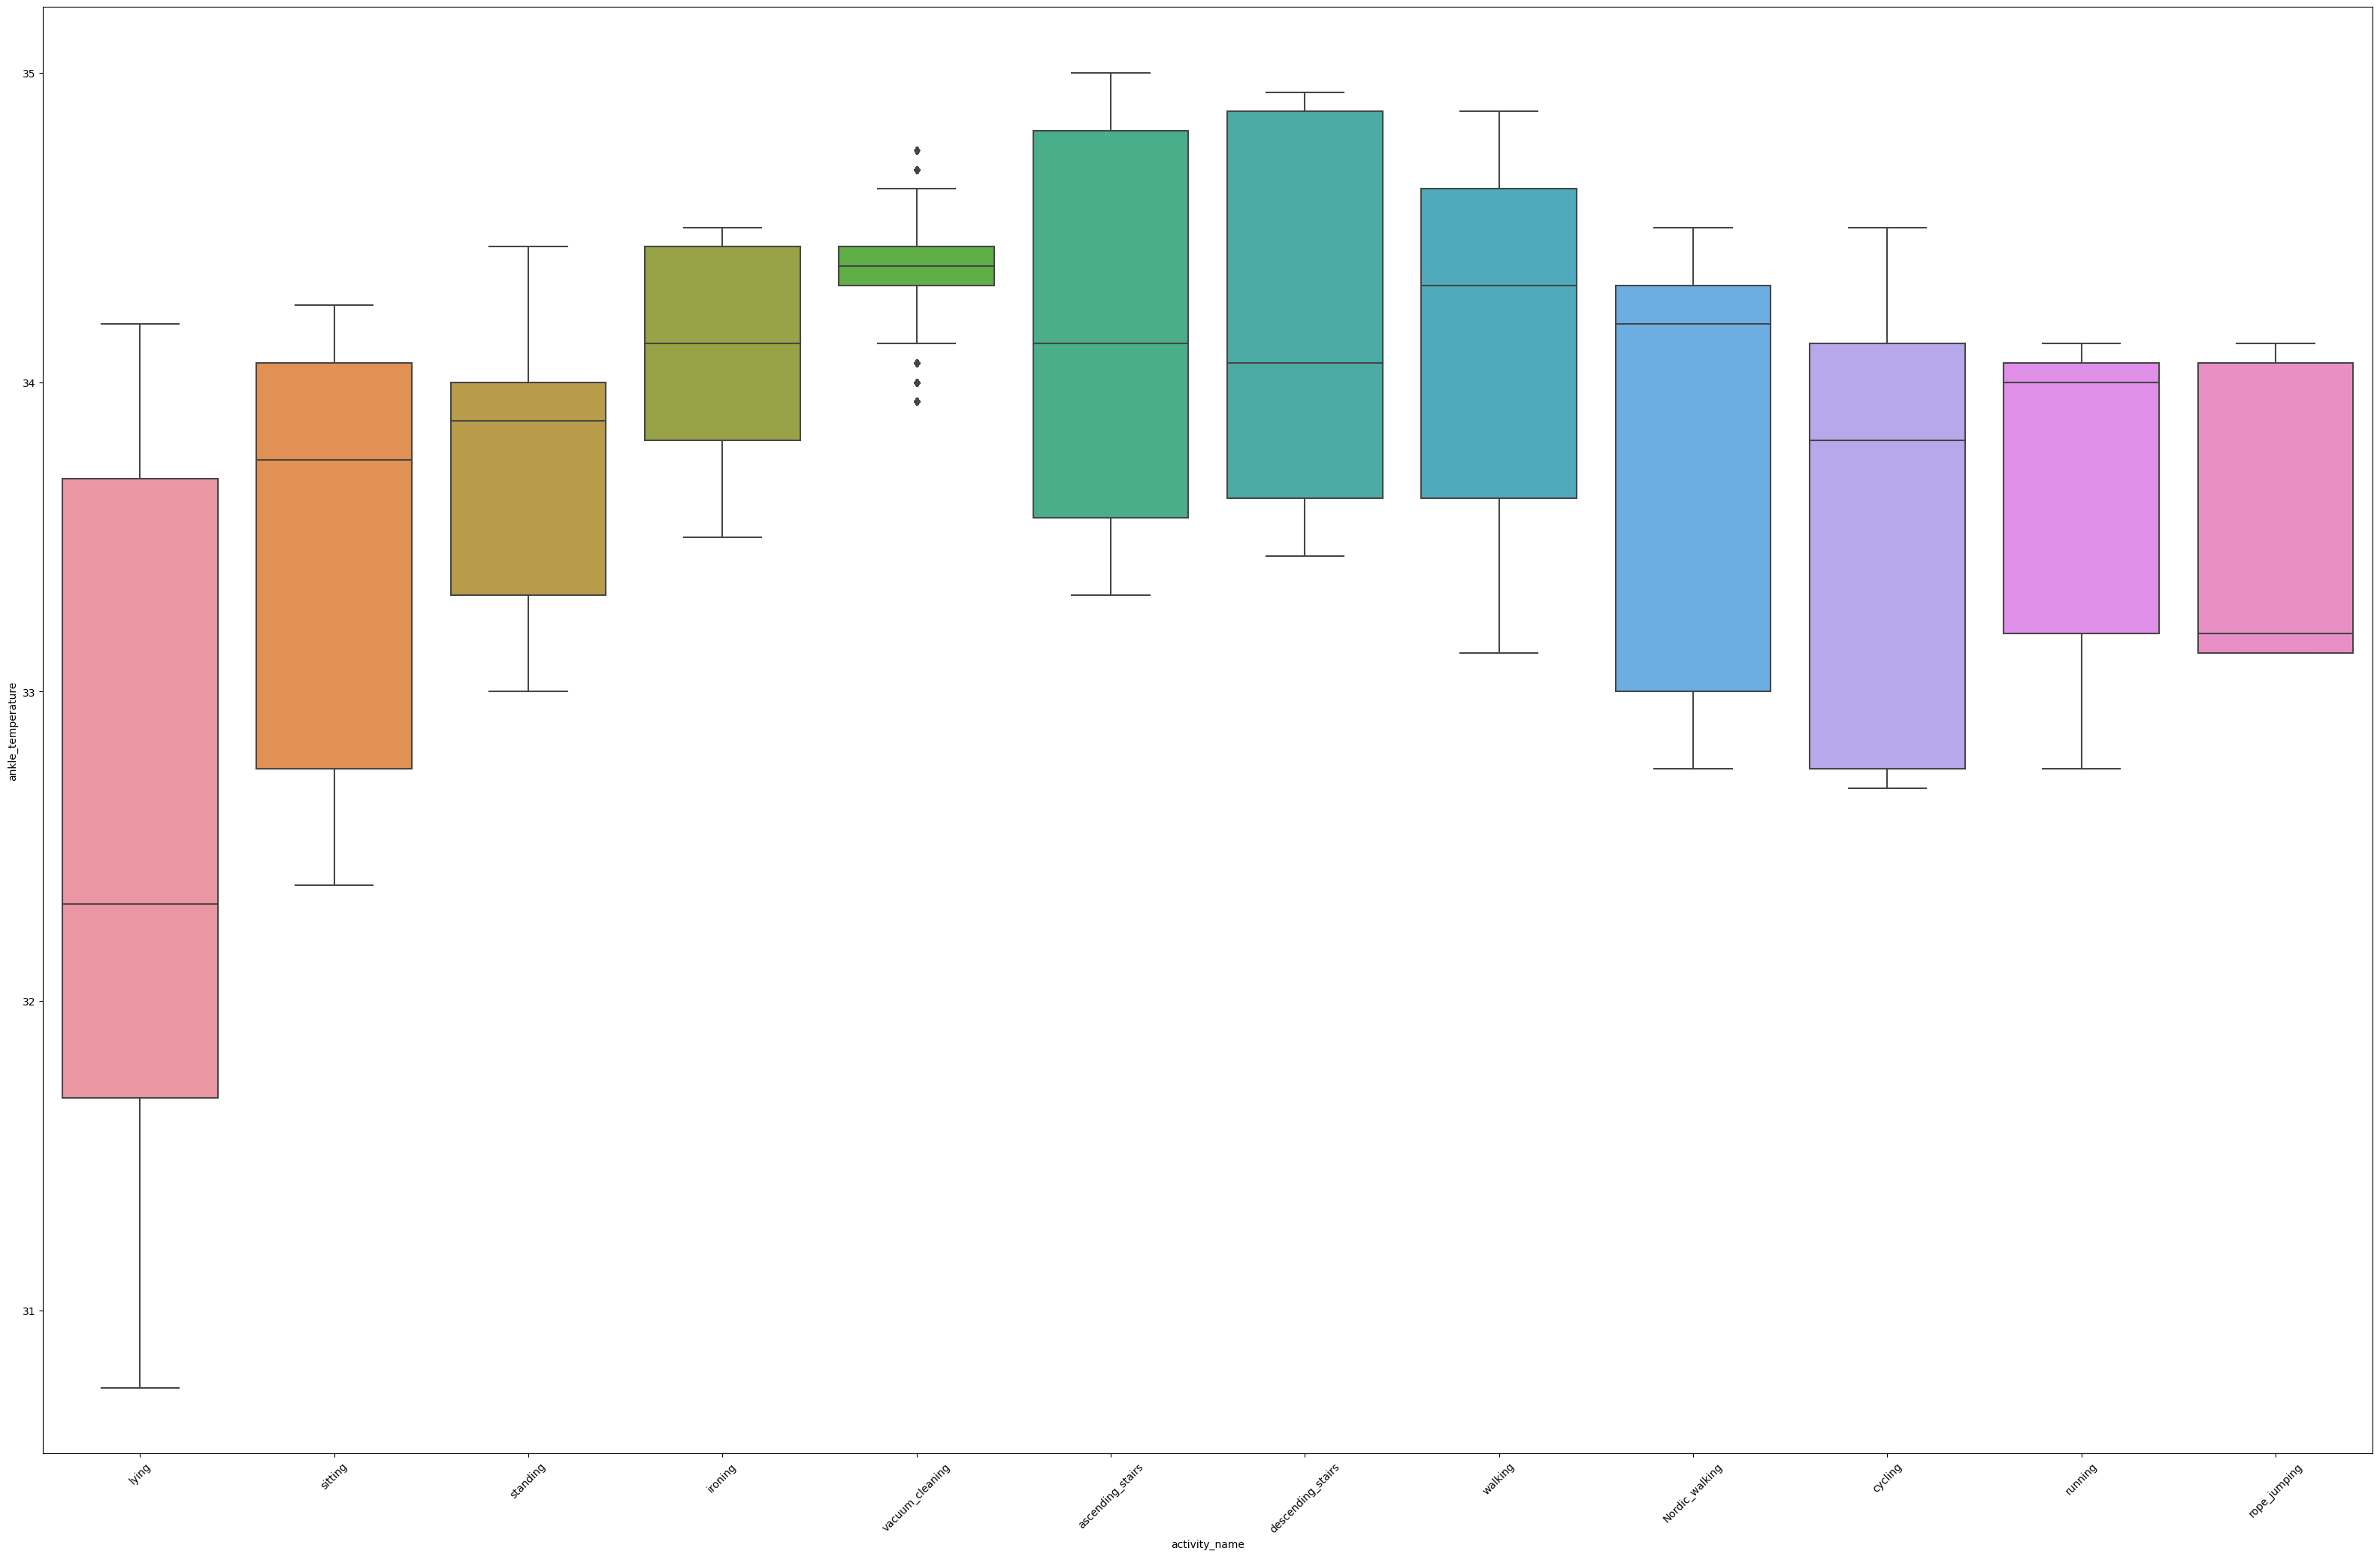

In [20]:
rcParams["figure.figsize"] = 40, 25
ax = sns.boxplot(x="activity_name", y="ankle_temperature", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotating Text
plt.show()

1. For ankle temperature, 'playing_soccer' has the least dispersed distribution.<br>
2. Outliers are mostly present in 'vacuum_cleaning' on the lower side.

* Boxplot of chest temperature grouped by activity_type

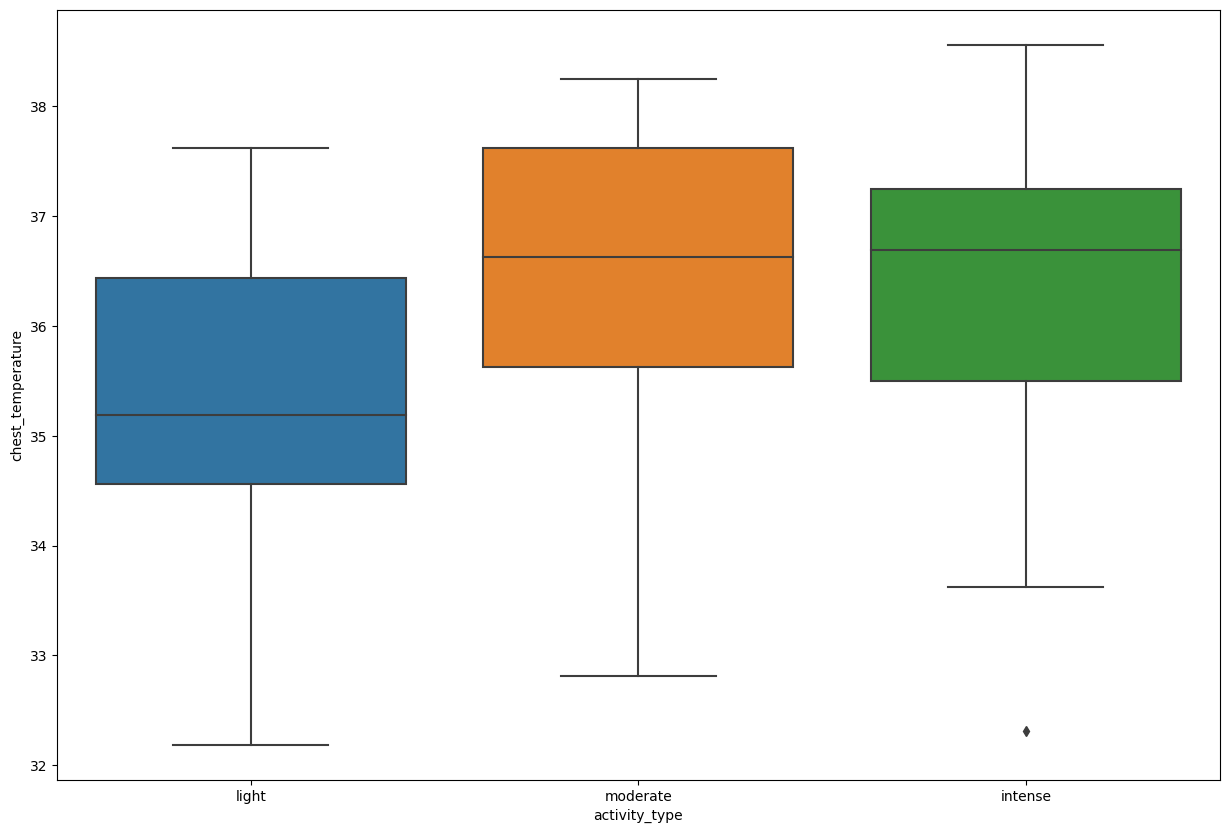

In [21]:
rcParams["figure.figsize"] = 15, 10
ax = sns.boxplot(x="activity_type", y="chest_temperature", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

1. For chest temperatures, only the 'intense' activity type has an outlier.<br>
2. For this feature as well, there doesn't seem to be much difference between<br>
   temperatures.

* Boxplot of chest temperature grouped by activity.

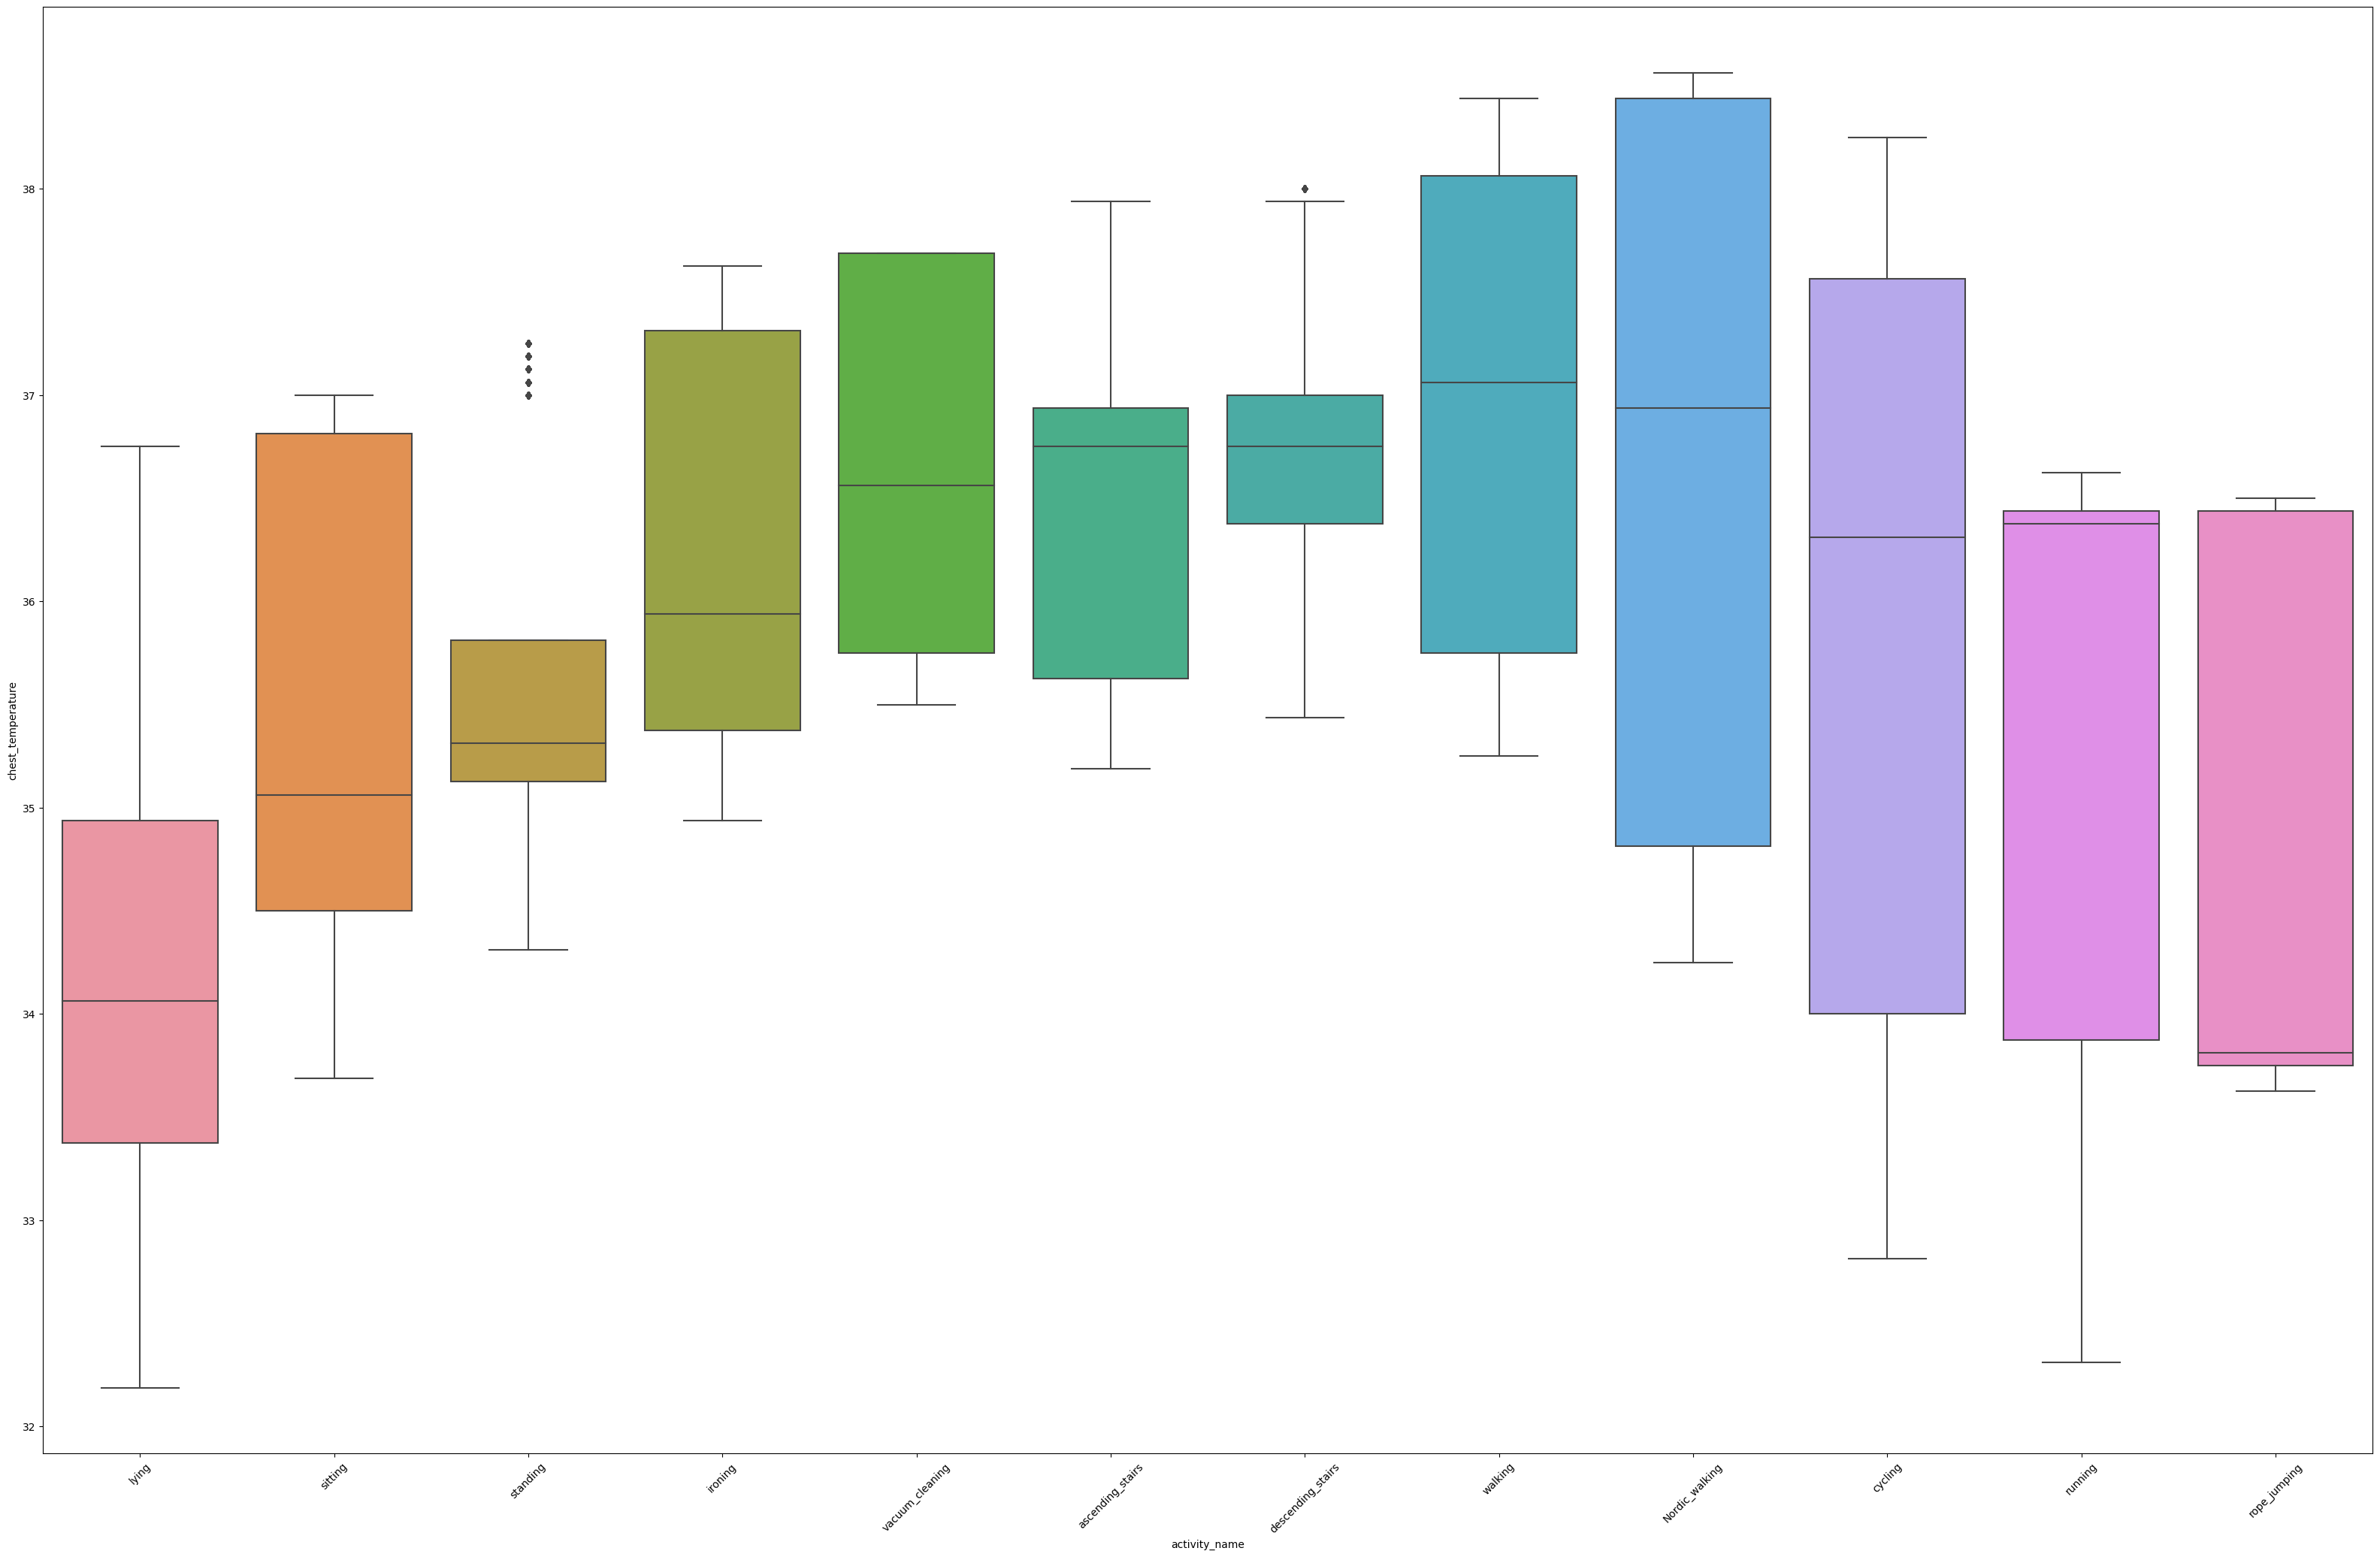

In [22]:
rcParams["figure.figsize"] = 40, 25
ax = sns.boxplot(x="activity_name", y="chest_temperature", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotating Text
plt.show()

1. Most of the activities seem to have a skewed distribution for chest temperature.<br>
2. 'car_driving' and 'watching_tv' seem to have the least dispersed distribution.

* A joint plot trying to investigate possibility of correlation between heart rate<br>
  and chest temperature.

<Figure size 4000x2500 with 0 Axes>

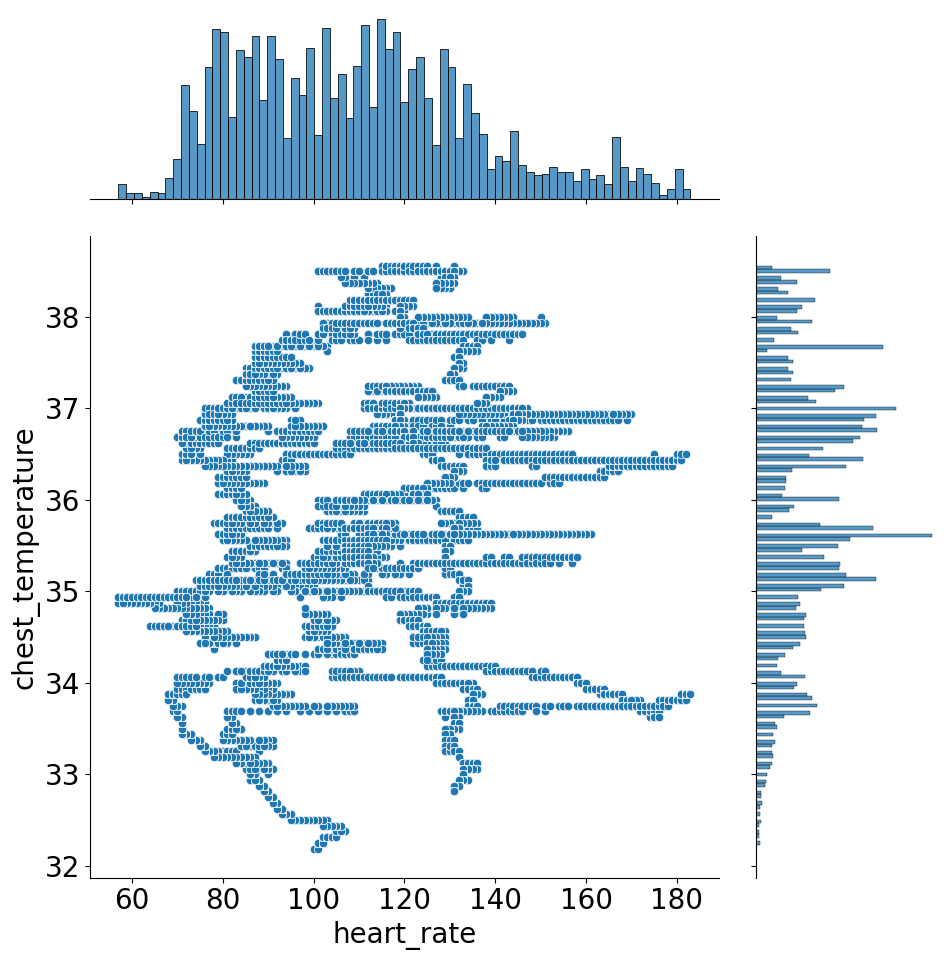

In [23]:
plt.clf()
rcParams["font.size"] = 20  # Setting the text and number font size
g = sns.JointGrid(data=train, x="heart_rate", y="chest_temperature", height=10, ratio=3)
g.plot_joint(sns.scatterplot, palette="colorblind")
g.plot_marginals(sns.histplot)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. From the scatter plot, we see that there does not seem to be a correlation between<br>
   the two variables.<br>
2. The respective histograms indicate that both the features considered have<br>
   a multi-modal distribution.

* Correlation map for relevant features

In [24]:
discard = [
    "activity_id",
    "activity",
    "time_stamp",
    "id",
]  # Columns to exclude from correlation map and descriptive statistics
train_trimmed = train[set(train.columns).difference(set(discard))]

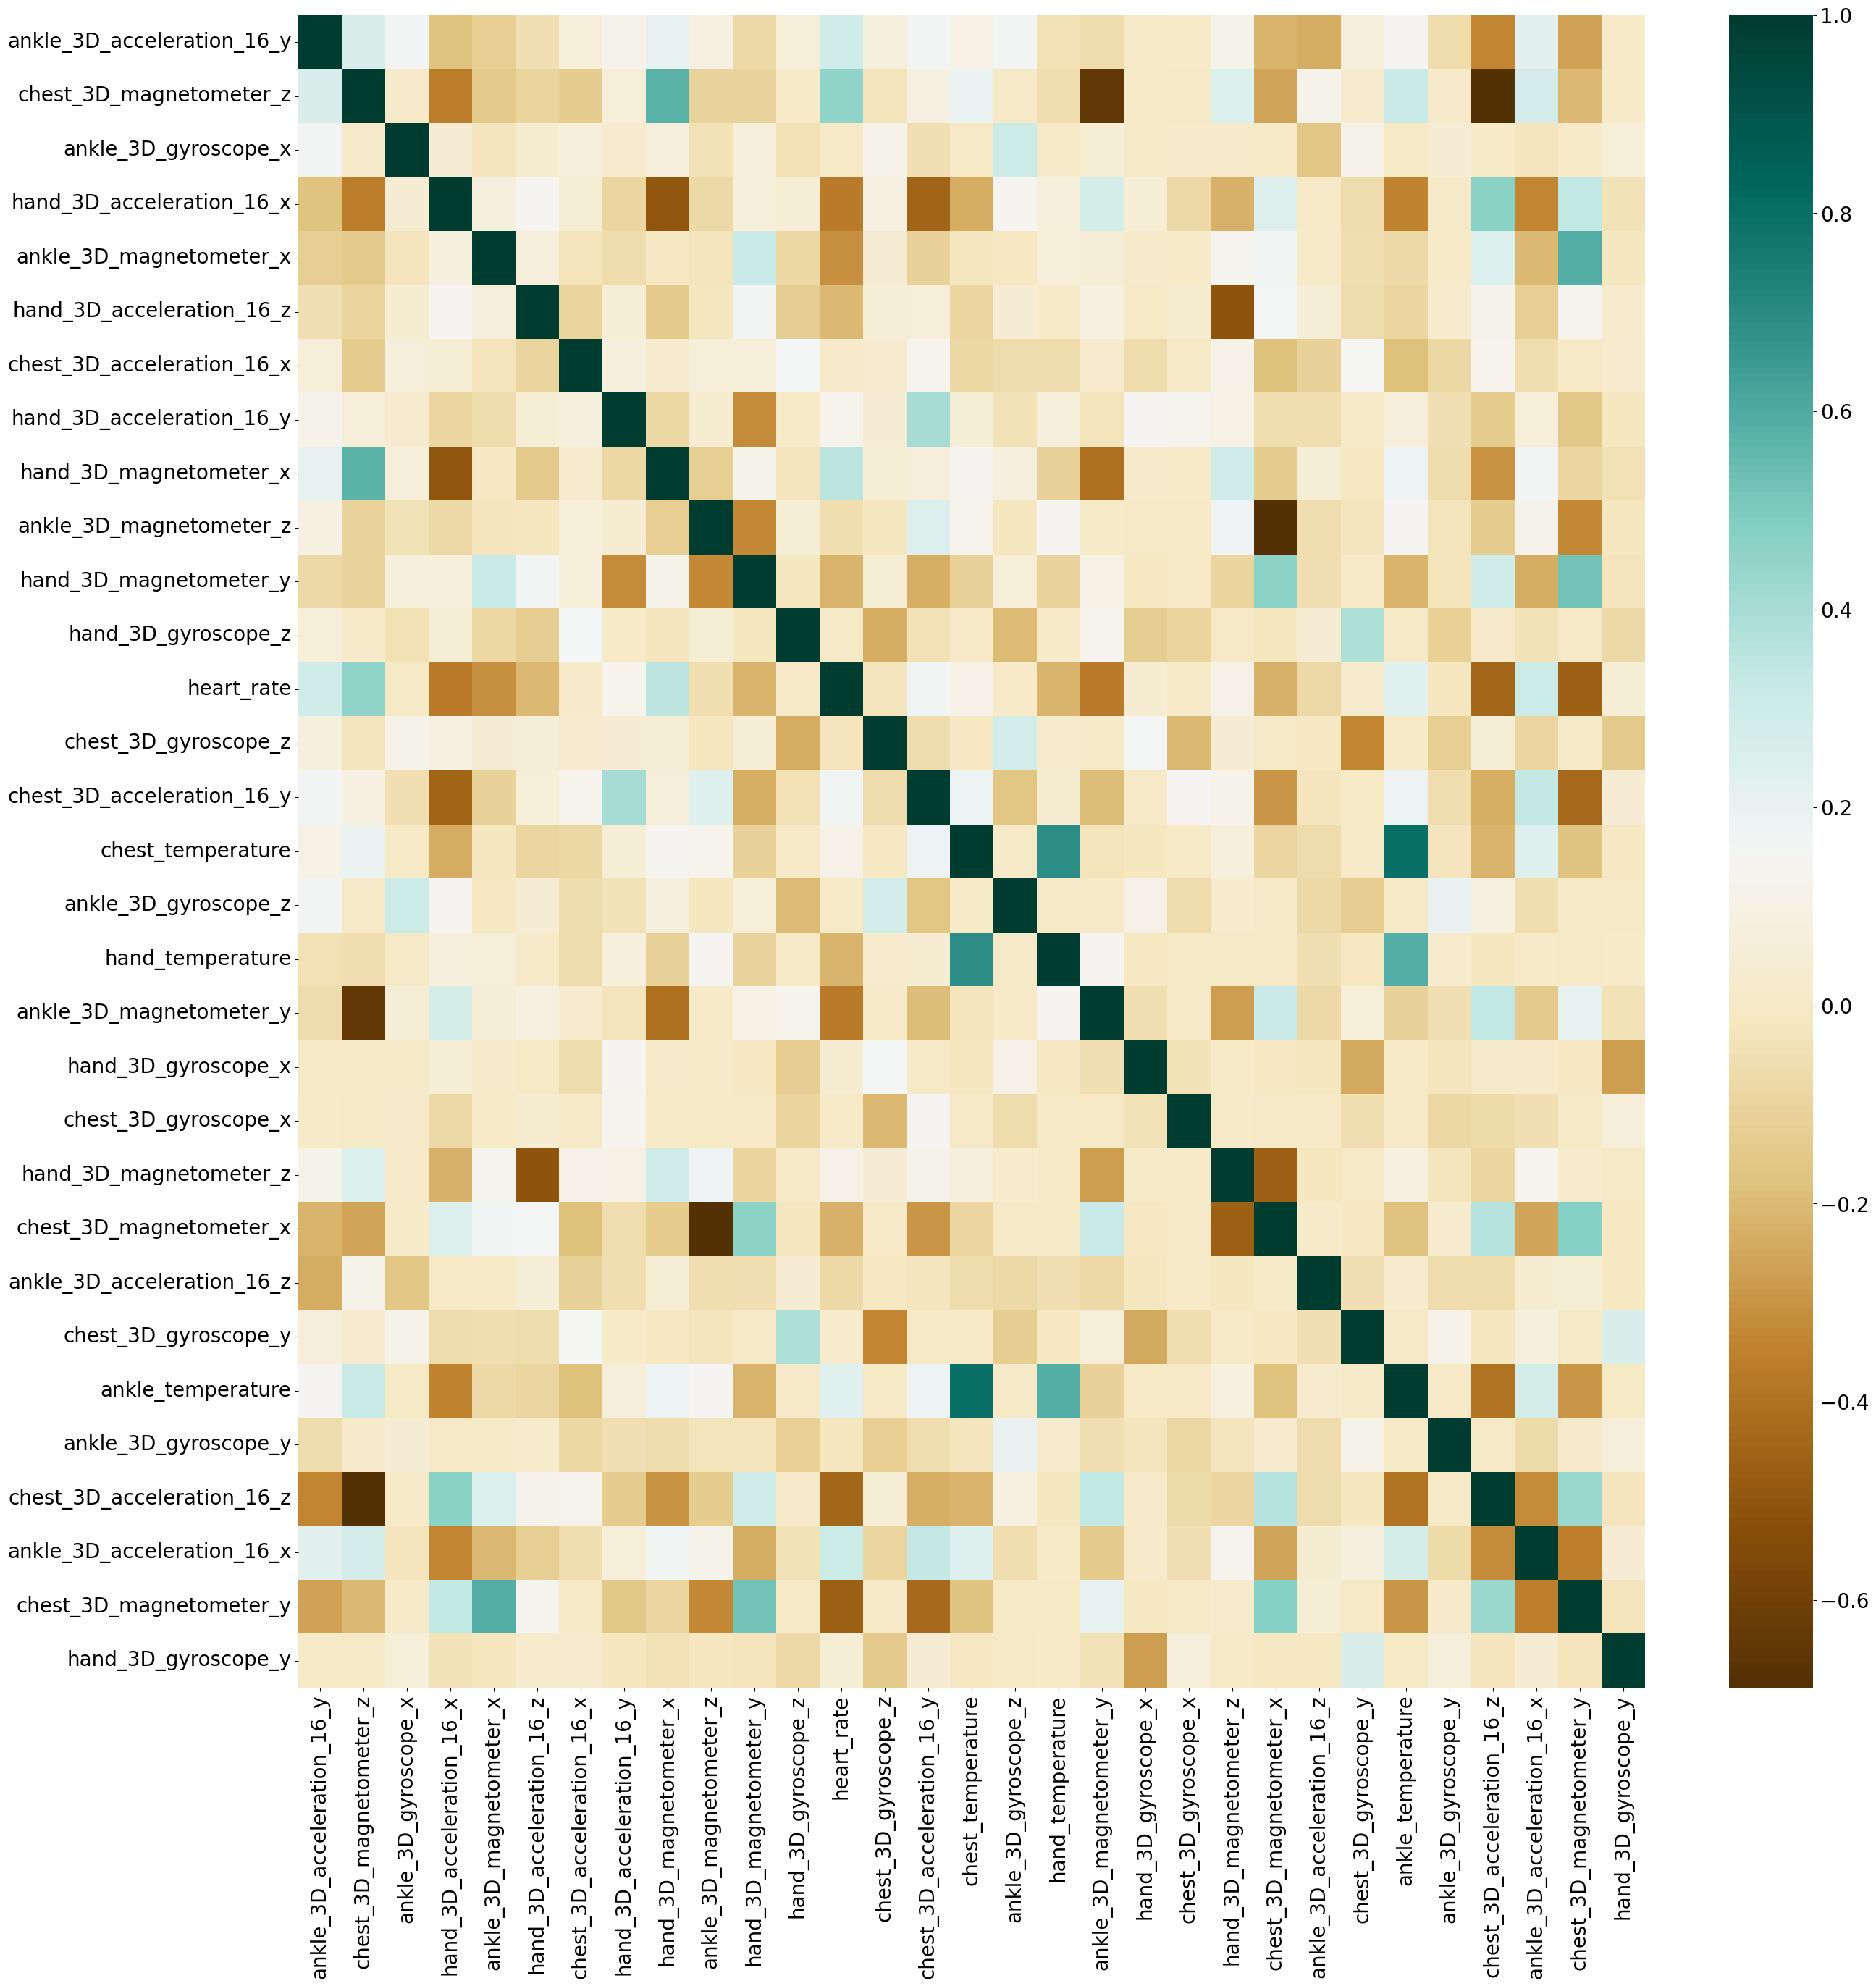

In [25]:
rcParams["figure.figsize"] = 30, 30
sns.heatmap(train_trimmed.corr(), cmap="BrBG")
plt.show()

### Descriptive Statistics<br>
Subject Details

In [26]:
display(subj_det)

,Subject ID,Sex,Age (years),Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,BMI
0,101,Male,27,182,83,75,193,right,25.057360
1,102,Female,25,169,78,74,195,right,27.309968
2,103,Male,31,187,92,68,189,right,26.309017
3,104,Male,24,194,95,58,196,right,25.241790
4,105,Male,26,180,73,70,194,right,22.530864
5,106,Male,26,183,69,60,194,right,20.603780
6,107,Male,23,173,86,60,197,right,28.734672
7,108,Male,32,179,87,66,188,left,27.152711
8,109,Male,31,168,65,54,189,right,23.030045


Mean of heart rate and temperatures for each activity

In [27]:
display(
    train.groupby(by="activity_name")[
        ["heart_rate", "chest_temperature", "hand_temperature", "ankle_temperature"]
    ].mean()
)

,heart_rate,chest_temperature,hand_temperature,ankle_temperature
activity_name,,,,
Nordic_walking,128.934574,36.640204,32.124192,33.778505
ascending_stairs,132.404398,36.586821,33.381660,34.146043
cycling,127.117356,35.894279,31.493273,33.617997
descending_stairs,130.733971,36.701044,33.195439,34.147815
ironing,94.586717,36.162343,33.845229,34.103435
...,...,...,...,...
running,158.613734,35.262980,32.372712,33.646088
sitting,82.242313,35.238913,33.025149,33.370173
standing,95.112994,35.590371,33.445441,33.742018


Descriptive info of relevant feature

In [28]:
display(train_trimmed.describe())

,ankle_3D_acceleration_16_y,chest_3D_magnetometer_z,ankle_3D_gyroscope_x,hand_3D_acceleration_16_x,ankle_3D_magnetometer_x,hand_3D_acceleration_16_z,chest_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_magnetometer_x,ankle_3D_magnetometer_z,...,hand_3D_magnetometer_z,chest_3D_magnetometer_x,ankle_3D_acceleration_16_z,chest_3D_gyroscope_y,ankle_temperature,ankle_3D_gyroscope_y,chest_3D_acceleration_16_z,ankle_3D_acceleration_16_x,chest_3D_magnetometer_y,hand_3D_gyroscope_y
count,924261.000000,927296.000000,924261.000000,922733.000000,924261.000000,922733.000000,927296.000000,922733.000000,922733.000000,924261.000000,...,922733.000000,927296.000000,924261.000000,927296.000000,924261.000000,924261.000000,927296.000000,924261.000000,927296.000000,922733.000000
mean,0.188150,3.616971,0.007019,-4.701216,-34.292921,3.819557,0.240625,4.867122,20.935601,16.765524,...,-25.306925,4.634805,-2.361436,0.009578,33.776342,-0.029152,-1.164960,9.377596,-32.789320,0.028274
std,7.470235,23.695410,1.022017,6.073816,21.381194,3.675067,1.736878,5.386418,25.717188,21.612666,...,22.172517,18.799139,3.727983,0.549806,0.761948,0.571440,4.721856,6.006841,19.382483,0.887466
min,-155.356000,-66.684700,-13.385600,-90.760600,-172.865000,-38.907800,-39.203400,-65.538700,-103.941000,-102.716000,...,-164.937000,-70.062700,-158.926000,-4.672250,30.750000,-7.807450,-53.401900,-66.308500,-122.480000,-7.609010
25%,-2.178640,-11.103325,-0.201214,-8.831980,-45.705600,1.721670,-0.580049,2.247180,2.499940,2.088300,...,-40.472500,-6.381310,-3.603550,-0.135082,33.375000,-0.130252,-3.827573,8.465960,-42.901700,-0.222837
50%,0.129326,1.054870,0.003077,-5.029430,-35.768600,3.721100,0.355426,4.385290,22.012300,20.468600,...,-24.964300,3.193960,-2.083400,-0.000901,34.000000,-0.006023,-1.233810,9.572440,-34.817800,0.008087
75%,1.927560,20.523525,0.095482,-0.525061,-17.365300,6.407160,1.035780,7.182090,40.078900,30.407100,...,-10.695900,14.399500,-0.649289,0.162768,34.312500,0.085158,0.835319,10.177500,-23.810575,0.279915
max,156.190000,96.358500,13.142500,42.891600,91.551600,76.639600,27.522300,154.576000,133.830000,122.521000,...,101.758000,80.473900,156.730000,4.540310,35.000000,6.410380,17.878100,155.166000,35.756300,13.251000


Variance of each axis of acceleration grouped by activities

In [29]:
coordinates = [i for i in train.columns if "acceleration" in i]
display(train.groupby(by="activity_name")[coordinates].var())

,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z
activity_name,,,,,,,,,
Nordic_walking,25.629540,58.398422,10.603472,2.575901,15.242082,6.148342,33.484057,92.289911,15.376649
ascending_stairs,23.543054,7.566316,5.824274,2.765901,10.775441,5.624425,42.033634,55.288195,28.013199
cycling,17.791446,15.649830,9.939227,0.715780,3.711593,4.622890,17.858721,12.164733,3.018095
descending_stairs,24.243241,11.550501,12.489337,2.984501,21.431527,4.440417,47.242317,70.014202,25.787439
ironing,10.310193,10.363109,13.358504,2.033213,0.736907,4.374898,0.174704,1.796946,1.696242
...,...,...,...,...,...,...,...,...,...
running,110.632062,212.062379,20.369313,8.078898,102.004097,9.118545,161.038054,228.653523,47.994581
sitting,10.279172,13.464679,10.087709,0.247896,0.804636,6.960005,6.838823,7.252916,8.381130
standing,20.283887,6.405919,3.793687,0.679866,0.068863,1.491701,0.081663,2.684077,1.072036


## Hypothesis Testing

Based on the exploratory data analysis carried out, the following hypotheses are tested on<br>
the test set:<br>
- Heart rate of moderate activities are greater than heart rate of light activities.<br>
- Heart rate of intense activities are greater than heart rate of light activities.<br>
- Chest acceleration along z axis is greater than that along x axis during lying.<br>
- Chest acceleration along x axis is greater than that along z axis during running.

Based on the EDA  we performed, it does not seem that the data is normally distributed. It is<br>
for this reason that Wilcoxon rank sum test was used to test the above hypothesis instead of the usual t-test which assumes that the samples follow a normal distribution.<br>
We test the above hypothesis using the confidence level of 5%.

### Hypothesis 1<br>
$H_0$(Null) : The heart rate during  moderate activities are the same or lower than that of light activities.<br>
$H_1$(Alternate) : The heart rate during moderate activities are likely to be higher during lying compared to light activities.

In [30]:
test1 = test[
    test.activity_type == "moderate"
].heart_rate.dropna()  # Heart rate of moderate activities with nan values dropped
test2 = test[
    test.activity_type == "light"
].heart_rate.dropna()  # Heart rate of light activities with nan values dropped
print(ranksums(test1, test2, alternative="greater"))

RanksumsResult(statistic=188.93129841668087, pvalue=0.0)


### Hypothesis 2<br>
$H_0$(Null) : The heart rate during intense activities are the same or lower than that of light activities.<br>
$H_1$(Alternate) : The heart rate during intense activities are likely to be higher during than during lower activities.

In [31]:
test1 = test[
    test.activity_type == "intense"
].heart_rate.dropna()  # Heart rate of moderate activities with nan values dropped
test2 = test[
    test.activity_type == "light"
].heart_rate.dropna()  # Heart rate of light activities with nan values dropped
print(ranksums(test1, test2, alternative="greater"))

RanksumsResult(statistic=225.13542455896652, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis.

### Hypothesis 3<br>
$H_0$(Null) : The z axis chest acceleration during lying is lower or same as the x axis acceleration.<br>
$H_1$(Alternate) :The z axis chest acceleration during lying is higher than the x axis acceleration.

In [32]:
test_l = test[test.activity_name == "lying"]
feature1 = "chest_3D_acceleration_16_z"
feature2 = "chest_3D_acceleration_16_x"
test1 = test_l[feature1]
test2 = test_l[feature2]
print(ranksums(test1, test2, alternative="greater"))

RanksumsResult(statistic=334.2705709425477, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis.

### Hypothesis 4<br>
$H_0$(Null) : The x axis chest acceleration during running is lower or same as the z axis acceleration.<br>
$H_1$(Alternate) :The x axis chest acceleration during lying is higher than the z axis acceleration.

In [ ]:
test_l = test[test.activity_name == "running"]
feature1 = "chest_3D_acceleration_16_x"
feature2 = "chest_3D_acceleration_16_z"
test1 = test_l[feature1]
test2 = test_l[feature2]
print(ranksums(test1, test2, alternative="greater"))

Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis.

## Model Prediction

In [33]:
clean_data = pd.read_pickle("clean_act_data.pkl")
discard = [
    "activity_id",
    "activity",
    "activity_name",
    "time_stamp",
    "id",
    "activity_type",
]  # Columns to exclude from descriptive stat

In [34]:
def spectral_centroid(signal):
    spectrum = np.abs(np.fft.rfft(signal))
    normalized_spectrum = spectrum / np.sum(
        spectrum
    )  # like a probability mass function
    normalized_frequencies = np.linspace(0, 1, len(spectrum))
    spectral_centroid = np.sum(normalized_frequencies * normalized_spectrum)
    return spectral_centroid

In [35]:
def sliding_window_feats(data, feats, win_len, step):
    final = []
    i = 0
    for i in range(0, len(data), 100):
        if (i + 256) > len(data):
            break
        temp = data.iloc[i : i + 256]
        temp1 = pd.DataFrame()
        for feat in feats:
            temp1[f"{feat}_roll_mean"] = [temp[feat].mean()]
            temp1[f"{feat}_roll_median"] = [temp[feat].median()]
            temp1[f"{feat}_roll_var"] = [temp[feat].var()]
            temp1[f"{feat}_spectral_centroid"] = [spectral_centroid(temp[feat])]
        temp1["time_stamp"] = [list(temp.time_stamp.values)[-1]]
        temp1[feats] = [temp[feats].iloc[-1]]
        temp1["activity_name"] = [temp["activity_name"].iloc[-1]]
        temp1["activity_type"] = [temp["activity_type"].iloc[-1]]
        final.append(temp1)
    final_data = pd.concat(final)
    return final_data

In [36]:
class modelling:
    def __init__(
        self,
        clean_data,
        features,
        train_subjects=[101, 103, 104, 105],
        val_subjects=[102, 106],
        test_subjects=[107, 108],
    ):
        self.clean_data = clean_data
        self.train_subjects = train_subjects
        self.val_subjects = val_subjects
        self.test_subjects = test_subjects
        self.features = features
    def split_input_data(self):
        train = self.clean_data[self.clean_data.id.isin(self.train_subjects)]
        val = self.clean_data[self.clean_data.id.isin(self.val_subjects)]
        test = self.clean_data[self.clean_data.id.isin(self.test_subjects)]
        x_train = train[self.features]
        x_val = val[self.features]
        x_test = test[self.features]
        return train, val, test, x_train, x_val, x_test
    def split_one_act(self, activity):
        train, val, test, x_train, x_val, x_test = self.split_input_data()
        one_hot_label = lambda x: 1 if x == activity else 0
        y_train = train.activity_name.apply(lambda x: one_hot_label(x))
        y_val = val.activity_name.apply(lambda x: one_hot_label(x))
        y_test = test.activity_name.apply(lambda x: one_hot_label(x))
        return x_train, x_val, x_test, y_train, y_val, y_test
    def train_test_split_acttype(self):
        le = preprocessing.LabelEncoder()
        train, val, test, x_train, x_val, x_test = self.split_input_data()
        y_train = le.fit_transform(train.activity_type)
        y_val = le.fit_transform(val.activity_type)
        y_test = le.fit_transform(test.activity_type)
        return x_train, x_val, x_test, y_train, y_val, y_test, le
    def train_test_split_actname(self):
        le = preprocessing.LabelEncoder()
        train, val, test, x_train, x_val, x_test = self.split_input_data()
        y_train = le.fit_transform(train.activity_name)
        y_val = le.fit_transform(val.activity_name)
        y_test = le.fit_transform(test.activity_name)
        return x_train, x_val, x_test, y_train, y_val, y_test, le

**Warning**: This cell takes a very long time to run.It is advised to use a debugger to run<br>
it line by line to check it.

In [37]:
def final_sliding_window(clean_data):
    feats = [i for i in clean_data.columns if i not in discard]
    final = []
    for i in clean_data.id.unique():
        temp = clean_data[clean_data.id == i]
        temp = sliding_window_feats(temp, feats, 256, 100)
        temp["id"] = [i] * len(temp)
        final.append(temp)
    clean_data_feats = pd.concat(final)
    clean_data_feats.to_pickle("activity_short_data.pkl")
    return clean_data_feats

**Remember to uncomment line below**<br>
final_sliding_window(clean_data)<br>
print(clean_data[[i for i in clean_data.columns if 'roll' in i]].head())

In [38]:
clean_data_feats = pd.read_pickle("activity_short_data.pkl")
features = [i for i in clean_data_feats.columns if i not in discard]
model = modelling(clean_data_feats, features)

In [39]:
(
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    le,
) = model.train_test_split_actname()

In [40]:
x_train_labels = pd.DataFrame()
x_train_labels["activity_name"] = le.inverse_transform(y_train)
ncluster = 92
clusters = dict()
recison = dict()

In [41]:
def precision(df):
    df.columns = ["activity", "labels"]
    act_precision = dict()
    for act in df.activity.unique():
        num = 0
        denom = 0
        df_act = df[df.activity == act]
        c_lab = df_act.labels.value_counts()
        for lab in df_act.labels.unique():
            clust_prob = len(df[(df.activity == act) & (df.labels == lab)]) / len(
                df[df.labels == lab]
            )
            num = num + clust_prob * c_lab[lab]
            denom = denom + c_lab[lab]
        act_precision[act] = num / denom
    return act_precision

takes time

In [ ]:
def best_cluster():
    v_measure = dict()
    for nclust in range(12, 112, 5):
        clust_vmeasure = []
        for col in x_train.columns:
            clust = cluster.KMeans(init="random", random_state=0, n_clusters=nclust)
            clust.fit(x_train[[col]])
            x_train_labels[f"{col}_label"] = clust.predict(x_train[[col]])
            clust_vmeasure.append(
                v_measure_score(y_train, x_train_labels[f"{col}_label"])
            )
        v_measure[nclust] = [np.array(clust_vmeasure).mean()]
    nclust_max = max(v_measure, key=v_measure.get)
    print(f"best cluster size : {nclust_max}")
    return v_measure

In [ ]:
vm = pd.DataFrame(best_cluster())
vm.to_pickle("v_measure.pkl")
print(vm)
# Not much difference found so using 100 clusters

In [42]:
def activity_precision():
    label_act_precision = dict()
    for i in x_train.columns:
        clust = cluster.KMeans(init="random", random_state=0, n_clusters=100)
        clust.fit(x_train[[i]])
        x_train_labels[f"{i}_label"] = clust.predict(x_train[[i]])
        label_act_precision[i] = precision(
            x_train_labels[["activity_name", f"{i}_label"]]
        )
    return label_act_precision

remember to uncomment for checking code<br>
lab_score = pd.DataFrame(activity_precision())<br>
lab_score.to_pickle("precision_score.pkl")

In [43]:
lab_score = pd.read_pickle("precision_score.pkl")

In [45]:
print("Precision score for each activity with respect to features")
display(lab_score)

Precision score for each activity with respect to features


,heart_rate_roll_mean,heart_rate_roll_median,heart_rate_roll_var,heart_rate_spectral_centroid,hand_temperature_roll_mean,hand_temperature_roll_median,hand_temperature_roll_var,hand_temperature_spectral_centroid,hand_3D_acceleration_16_x_roll_mean,hand_3D_acceleration_16_x_roll_median,...,ankle_temperature,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z
lying,0.455853,0.431733,0.104899,0.143018,0.271622,0.268411,0.103398,0.119304,0.623959,0.603967,...,0.544236,0.669346,0.638409,0.280926,0.192204,0.217654,0.188390,0.445244,0.398455,0.440461
sitting,0.391306,0.346571,0.115548,0.178038,0.315299,0.334890,0.113222,0.115215,0.367896,0.358682,...,0.340510,0.193292,0.228746,0.159559,0.208603,0.211559,0.205537,0.252153,0.245982,0.252815
standing,0.275178,0.250888,0.107018,0.166468,0.256440,0.228183,0.096624,0.109796,0.203729,0.204675,...,0.216246,0.181706,0.145693,0.168604,0.159500,0.161572,0.166857,0.366012,0.162765,0.174681
ironing,0.282338,0.268731,0.121790,0.172501,0.381690,0.345249,0.119199,0.130739,0.289115,0.298405,...,0.214099,0.220415,0.223714,0.169422,0.153759,0.151911,0.184266,0.204489,0.174952,0.420613
vacuum_cleaning,0.198205,0.183877,0.096760,0.118806,0.493016,0.282830,0.095684,0.109881,0.166845,0.153211,...,0.238620,0.136398,0.127152,0.117827,0.117184,0.123753,0.146860,0.168646,0.106777,0.140858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
walking,0.460744,0.476686,0.132834,0.180442,0.273013,0.272233,0.129632,0.153201,0.540319,0.486249,...,0.199827,0.183871,0.155100,0.149542,0.244127,0.223216,0.287889,0.183700,0.138876,0.164516
Nordic_walking,0.266481,0.289097,0.080976,0.127345,0.299313,0.357335,0.083645,0.102494,0.172165,0.143370,...,0.202204,0.132743,0.098768,0.098866,0.150358,0.127642,0.181353,0.111933,0.098664,0.105336
cycling,0.263453,0.281219,0.081427,0.158209,0.358545,0.392151,0.077282,0.100063,0.176076,0.170288,...,0.189539,0.164957,0.199851,0.097500,0.148157,0.123565,0.193060,0.107823,0.126535,0.099156
running,0.487838,0.497142,0.052877,0.123885,0.333952,0.209720,0.054688,0.062926,0.182927,0.114477,...,0.217829,0.137615,0.121906,0.086637,0.109845,0.157709,0.249540,0.062401,0.082414,0.060666


In [46]:
def one_act_model(act, low_index, up_index, lab_score):
    lab_score = lab_score.T
    best_feats = list(
        lab_score[act].sort_values(ascending=False).index[low_index:up_index]
    )
    model = modelling(clean_data_feats, best_feats)
    x_train, x_val, x_test, y_train, y_val, y_test = model.split_one_act(act)
    pca = PCA(n_components=0.99)
    x_train = pca.fit_transform(x_train)
    x_val = pca.transform(x_val)
    x_test = pca.transform(x_test)
    f1 = []
    acc = []
    for lam in np.arange(0.1, 1, 0.1):
        lr = LogisticRegression(solver="saga", random_state=30, C=1 / lam)
        lr.fit(x_train, y_train)
        f1.append(f1_score(y_val, lr.predict(x_val)))
        acc.append(accuracy_score(y_val, lr.predict(x_val)))
    df_lr = pd.DataFrame()
    df_lr["validation_accuracy"] = acc
    df_lr["f1"] = f1
    df_lr["lambda"] = np.arange(0.1, 1, 0.1)
    return df_lr, model, best_feats

In [48]:
df_lr_best_feat, best_model, best_feats = one_act_model("lying", 0, 4, lab_score)
df_lr_worst_feat, worst_model, worst_feats = one_act_model("lying", -4, -1, lab_score)
print("best feature performance")
display(df_lr_best_feat)
print("worst feature performance")
display(df_lr_worst_feat)
print("done")

best feature performance


,validation_accuracy,f1,lambda
0,0.994152,0.966518,0.1
1,0.994152,0.966518,0.2
2,0.994152,0.966518,0.3
3,0.994152,0.966518,0.4
4,0.994152,0.966518,0.5
5,0.994152,0.966518,0.6
6,0.994152,0.966518,0.7
7,0.994152,0.966518,0.8
8,0.994152,0.966518,0.9


worst feature performance


,validation_accuracy,f1,lambda
0,0.909747,0.0,0.1
1,0.909747,0.0,0.2
2,0.909747,0.0,0.3
3,0.909747,0.0,0.4
4,0.909747,0.0,0.5
5,0.909747,0.0,0.6
6,0.909747,0.0,0.7
7,0.909747,0.0,0.8
8,0.909747,0.0,0.9


done


Since all \lambda values give the same results we use just lambda = 0.9 and test this final model on test set.

In [49]:
lam = 0.9
x_train, x_val, x_test, y_train, y_val, y_test = best_model.split_one_act("lying")
lr = LogisticRegression(solver="saga", random_state=30, C=1 / lam)
lr.fit(x_train, y_train)
print("Test Set Results")
print(classification_report(y_test, lr.predict(x_test)))
print(f"Best Features for lying: {best_feats}")
print(f"Worst Features for lying: {worst_feats}")

Test Set Results
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4451
           1       1.00      0.95      0.97       494

    accuracy                           0.99      4945
   macro avg       1.00      0.97      0.98      4945
weighted avg       0.99      0.99      0.99      4945

Best Features for lying: ['ankle_3D_acceleration_16_y_roll_median', 'ankle_3D_acceleration_16_x_roll_mean', 'ankle_3D_acceleration_16_x_roll_median', 'chest_3D_acceleration_16_z_roll_median']
Worst Features for lying: ['heart_rate_roll_var', 'ankle_temperature_roll_var', 'chest_temperature_roll_var']


prediction using Clustering<br>
for clustering we will select top 4 attributes with best precision for each activity.<br>
best Feature list

In [50]:
feat_score = lab_score.T
best_feats = np.concatenate(
    [
        list(feat_score[act].sort_values(ascending=False).index[0:4])
        for act in feat_score.columns
    ]
)

In [51]:
cluster_pred = modelling(clean_data_feats, best_feats)
(
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    le,
) = cluster_pred.train_test_split_actname()

In [52]:
def determine_ncluster(x_train, y_train):
    v_measure_feats = defaultdict(list)
    for ncluster in range(12, 100, 5):
        clust = cluster.KMeans(init="random", random_state=0, n_clusters=ncluster)
        clust.fit(x_train)
        y_lab = clust.predict(x_train)
        v_measure_feats[ncluster].append(v_measure_score(y_train, y_lab))
        print(f"cluster {ncluster} done")
    return v_measure_feats

remember to uncomment to genereate homogeneity score<br>
v_measure_feats = determine_ncluster(x_train, y_train)<br>
pd.DataFrame(v_measure_feats).to_pickle("multiple_feature_vmeasure.pkl")

In [54]:
v_measure = pd.read_pickle("multiple_feature_vmeasure.pkl")
ncluster = v_measure.idxmax(axis=1).values[0]
print(f"Optimal No. of Clusters:{ncluster}")
clf = cluster.KMeans(init="random", n_clusters=ncluster, random_state=0)
clf.fit(x_train, y_train)
x_train_labels = x_train.copy()
x_train_labels["labels"] = clf.predict(x_train)
x_train_labels["activity_name"] = le.inverse_transform(y_train)
xc = pd.DataFrame(
    index=x_train_labels.activity_name.unique(),
    columns=x_train_labels.labels.unique(),
)
for i in range(ncluster):
    temp = x_train_labels[x_train_labels.labels == i]
    for j in x_train_labels.activity_name.unique():
        clust_prob = len(temp[temp.activity_name == j]) / len(temp)
        xc.loc[j, i] = clust_prob
display(xc)
xc = xc.astype("float")
x_val_labels = pd.DataFrame(x_val).copy()
x_val_labels["activity_name"] = le.inverse_transform(y_val)
x_val_labels["labels"] = clf.predict(x_val)
x_val_labels["predicted_activity"] = x_val_labels.labels.apply(
    lambda x: xc[[x]].idxmax().values[0]
)
print("accuracy: ")
print(
    len(x_val_labels[x_val_labels.activity_name == x_val_labels.predicted_activity])
    / len(x_val_labels)
)
print("Thank You")

Optimal No. of Clusters:57


,37,18,50,12,0,47,32,7,28,40,...,20,23,1,54,41,19,10,17,56,35
lying,0.159574,0.023529,0.131313,1.0,1.0,0.003436,0.978261,1.0,1.0,0.0,...,0.0,0.104575,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
sitting,0.425532,0.011765,0.0,0.0,0.0,0.993127,0.0,0.0,0.0,0.592105,...,0.0,0.0,0.101961,0.925,0.714286,0.020134,0.0,0.0,0.995392,0.0
standing,0.37234,0.0,0.0,0.0,0.0,0.003436,0.0,0.0,0.0,0.385965,...,0.0,0.019608,0.854902,0.020833,0.0,0.026846,0.0,0.0,0.0,0.0
ironing,0.0,0.0,0.010101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.078431,0.031373,0.0,0.214286,0.939597,0.0,0.0,0.0,0.0
vacuum_cleaning,0.0,0.388235,0.414141,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,...,0.0,0.79085,0.011765,0.054167,0.071429,0.010067,0.0,0.0,0.004608,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
walking,0.031915,0.011765,0.121212,0.0,0.0,0.0,0.0,0.0,0.0,0.004386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nordic_walking,0.0,0.117647,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cycling,0.0,0.329412,0.080808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0,0.0
running,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.0,1.0


accuracy: 
0.724756335282651
Thank You
